In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from utils import pretty_adf, pretty_coint, pretty_kpss

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (16, 9)

In [2]:
import statsmodels.api as sm
import statsmodels.tsa.api as tsa

In [3]:
def data_sim(n_obs, beta=.1, alpha=.15, ly=.05, lx=.01, x_eq=2, n_spurious=1, start='2020-01-01', sigma_shocks=.1, drift_x=0, frac_noise=0.3):
  x_causal = [100]
  y = [20]

  for i in range(n_obs-1):
    dx = np.random.normal(0, sigma_shocks) + drift_x
    
    dy = ly*dx - alpha*(y[i] - beta*x_causal[i]) + frac_noise*np.random.normal(0, 1)
    
    x_new = x_eq  + (1 - lx)*(x_causal[i] - x_eq)  + dx
    x_causal.append(x_new)
    y_new =  y[i] + dy
    y.append(y_new)
  return pd.DataFrame({'x_causal': x_causal, 'y': y} | {f'x_spurious_{i}': np.random.normal(0, sigma_shocks, n_obs).cumsum() for i in range(n_spurious)}, index=pd.date_range(start, periods=n_obs, freq='W-MON'))

In [4]:
def dgp(beta, rho, sigma_x=0, sigma_z=0, theta=0, T=156, n_spurious=0, rho_x=1):
  e_zt, e_xt = np.random.multivariate_normal([0, 0], [[sigma_z**2, theta*sigma_x*sigma_z], [theta*sigma_z*sigma_x, sigma_x**2]], T).T
  zt = np.zeros(T)
  xt = np.zeros(T)
  yt = np.zeros(T)
  spurious = np.random.normal(0, sigma_x, (T, n_spurious)).cumsum(axis=0) + 100 if n_spurious > 0 else np.zeros((T, 0))
  zt[0] = np.random.normal(0, sigma_z)
  yt[0] = np.random.normal(0, sigma_z)+100*beta
  xt[0] = np.random.normal(0, sigma_x)+100
  for t in range(1, T):
    zt[t] = rho*zt[t-1] + e_zt[t]
    xt[t] = rho_x*xt[t-1] + e_xt[t]
    yt[t] = beta*xt[t] + zt[t]
  data = pd.DataFrame({'y': yt, 'x_causal': xt} | {f'x_spurious_{i}': spurious[:, i] for i in range(n_spurious)}, index=pd.date_range('2020-01-01', periods=T, freq='W-MON'))
  return data

In [5]:
from datetime import datetime

Text(0.5, 1.0, 'Simulated data')

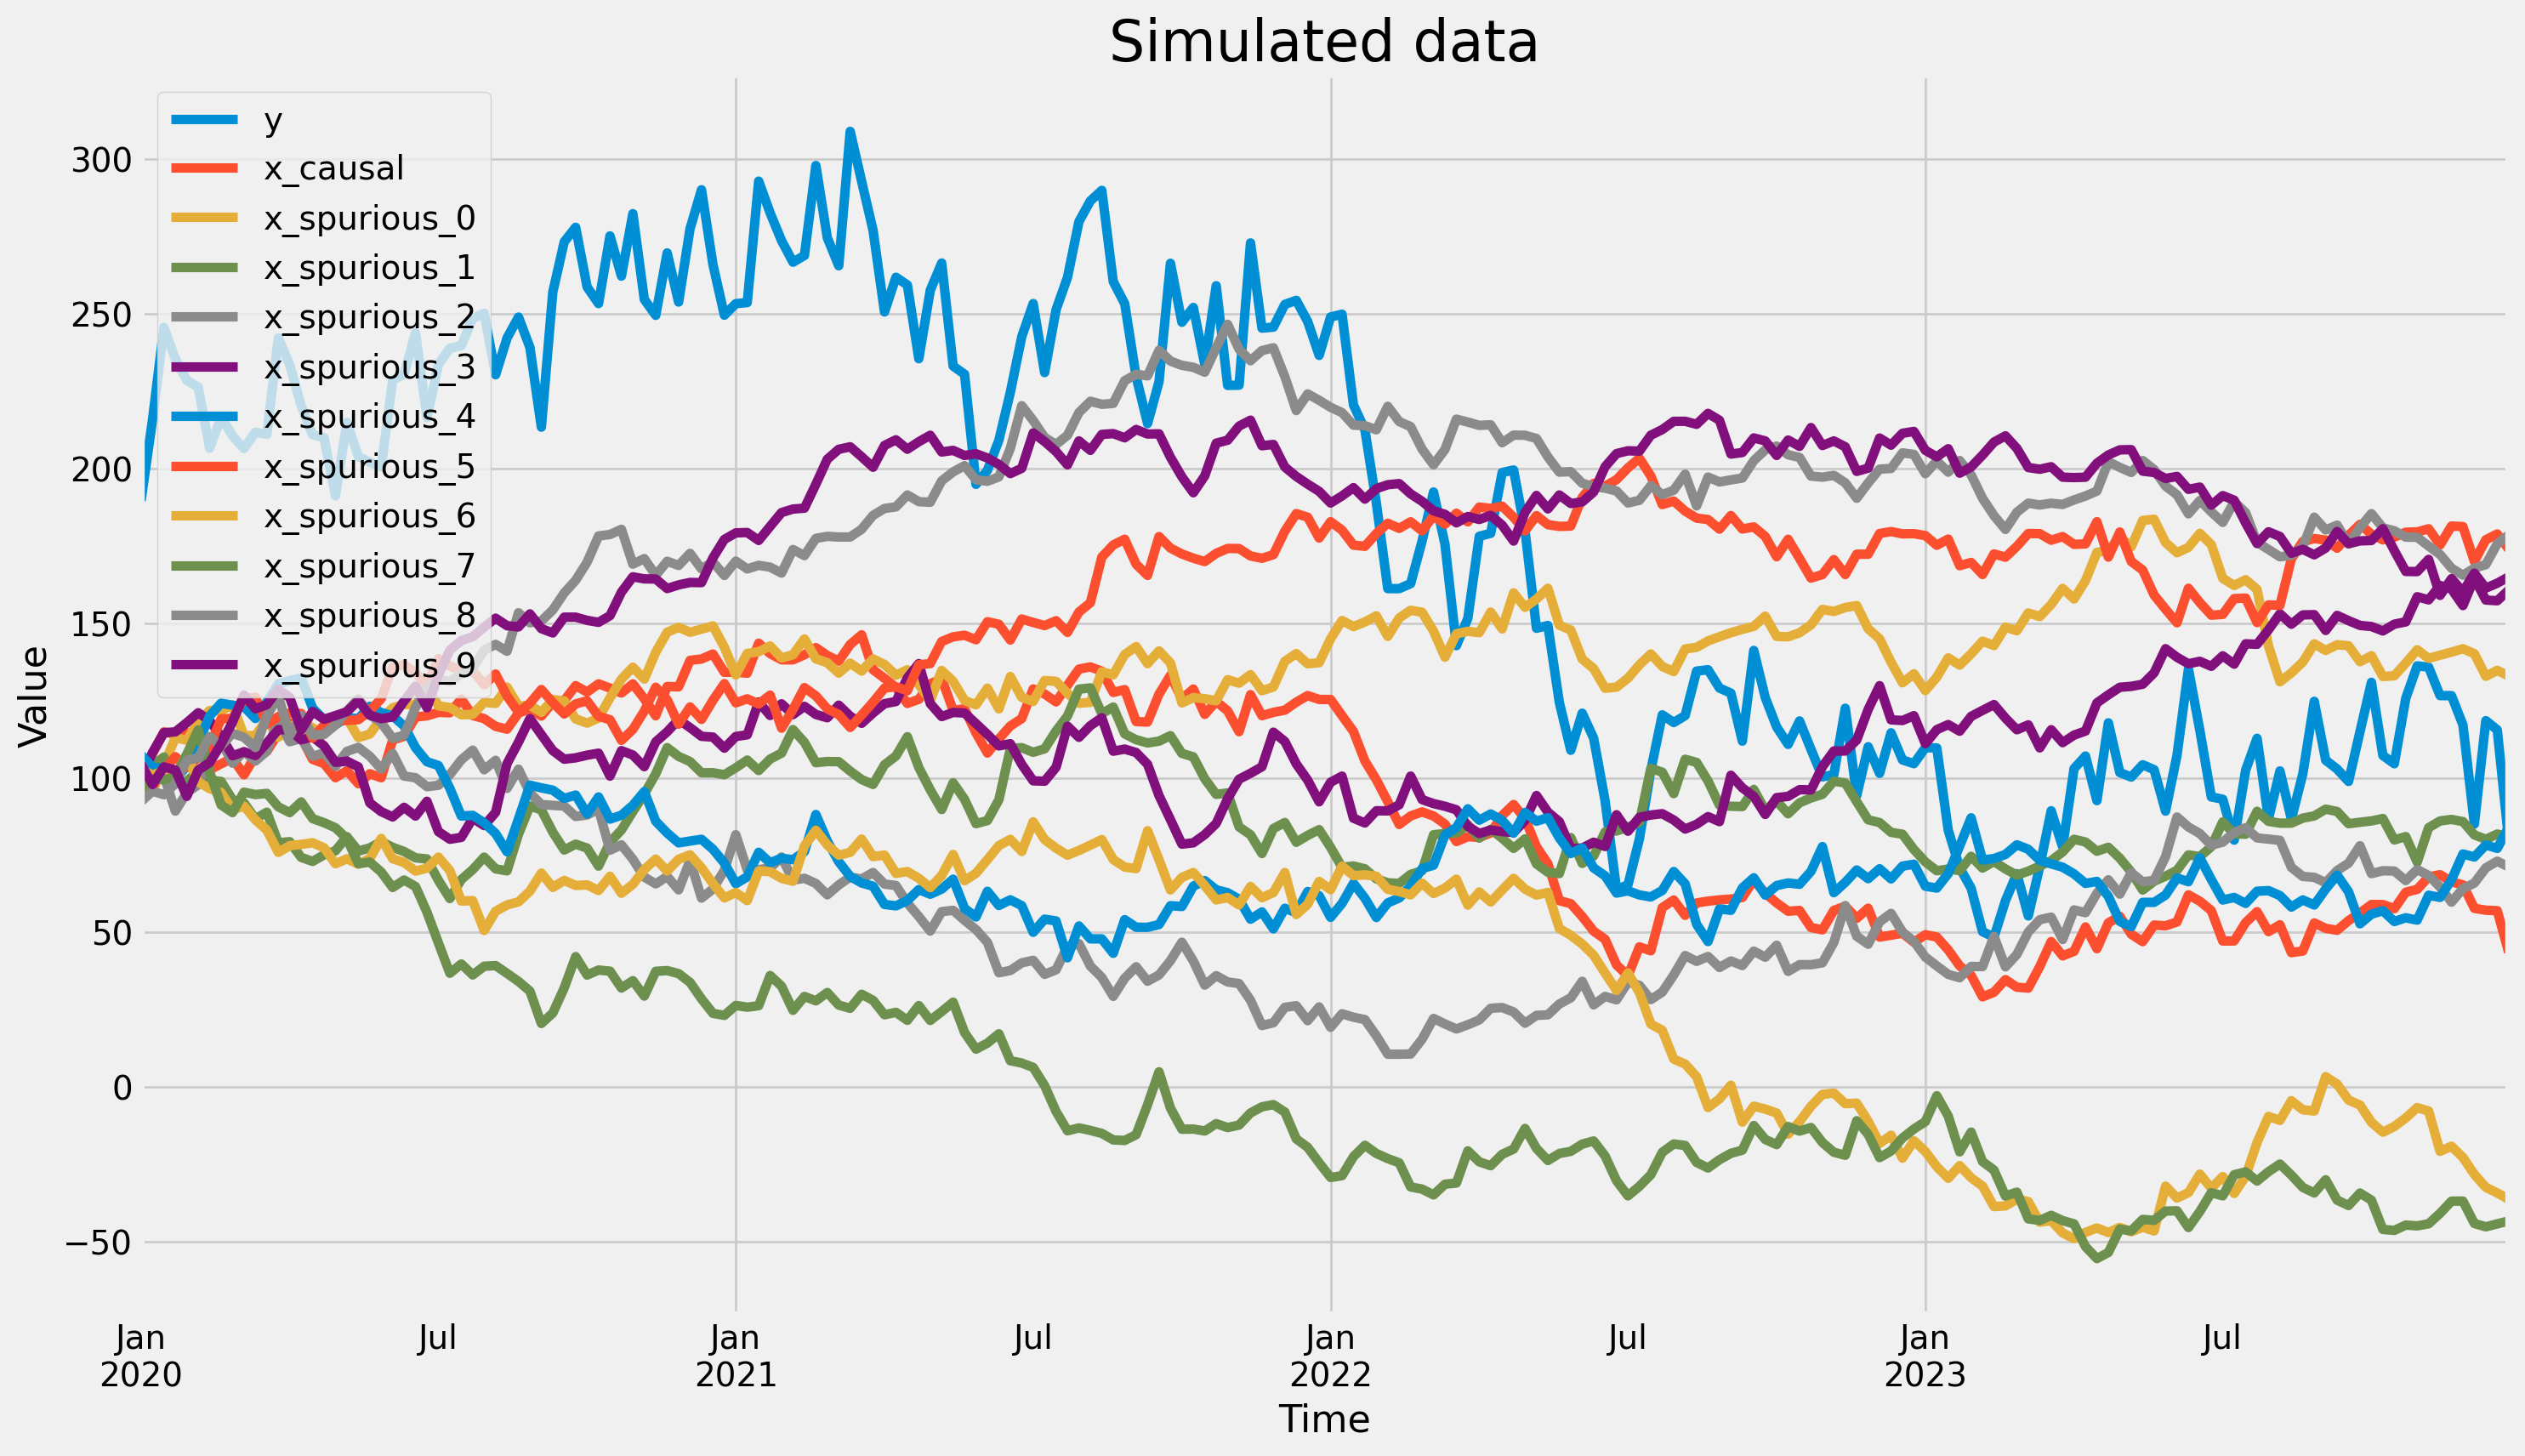

In [195]:
#data = pd.read_csv('simulated_data.csv', index_col=0) 
#data = data_sim(208, beta=1.7, ly=1, alpha=0.2, lx=0, x_eq=15, n_spurious=3, sigma_shocks=3, drift_x=0, frac_noise=1)
#data.index = pd.to_datetime(data.index)
created = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
data = dgp(2, 0.3, sigma_x=5, sigma_z=10, theta=0.2, T=208, n_spurious=10, rho_x=1)
data.plot()
plt.xlabel('Time', fontdict={'fontsize': 16})
plt.ylabel('Value', fontdict={'fontsize': 16})
plt.title('Simulated data', fontdict={'fontsize': 24})

In [196]:
def hill(x, k=30, s=1.4):
  return (x**s)/(x**s + k**s)

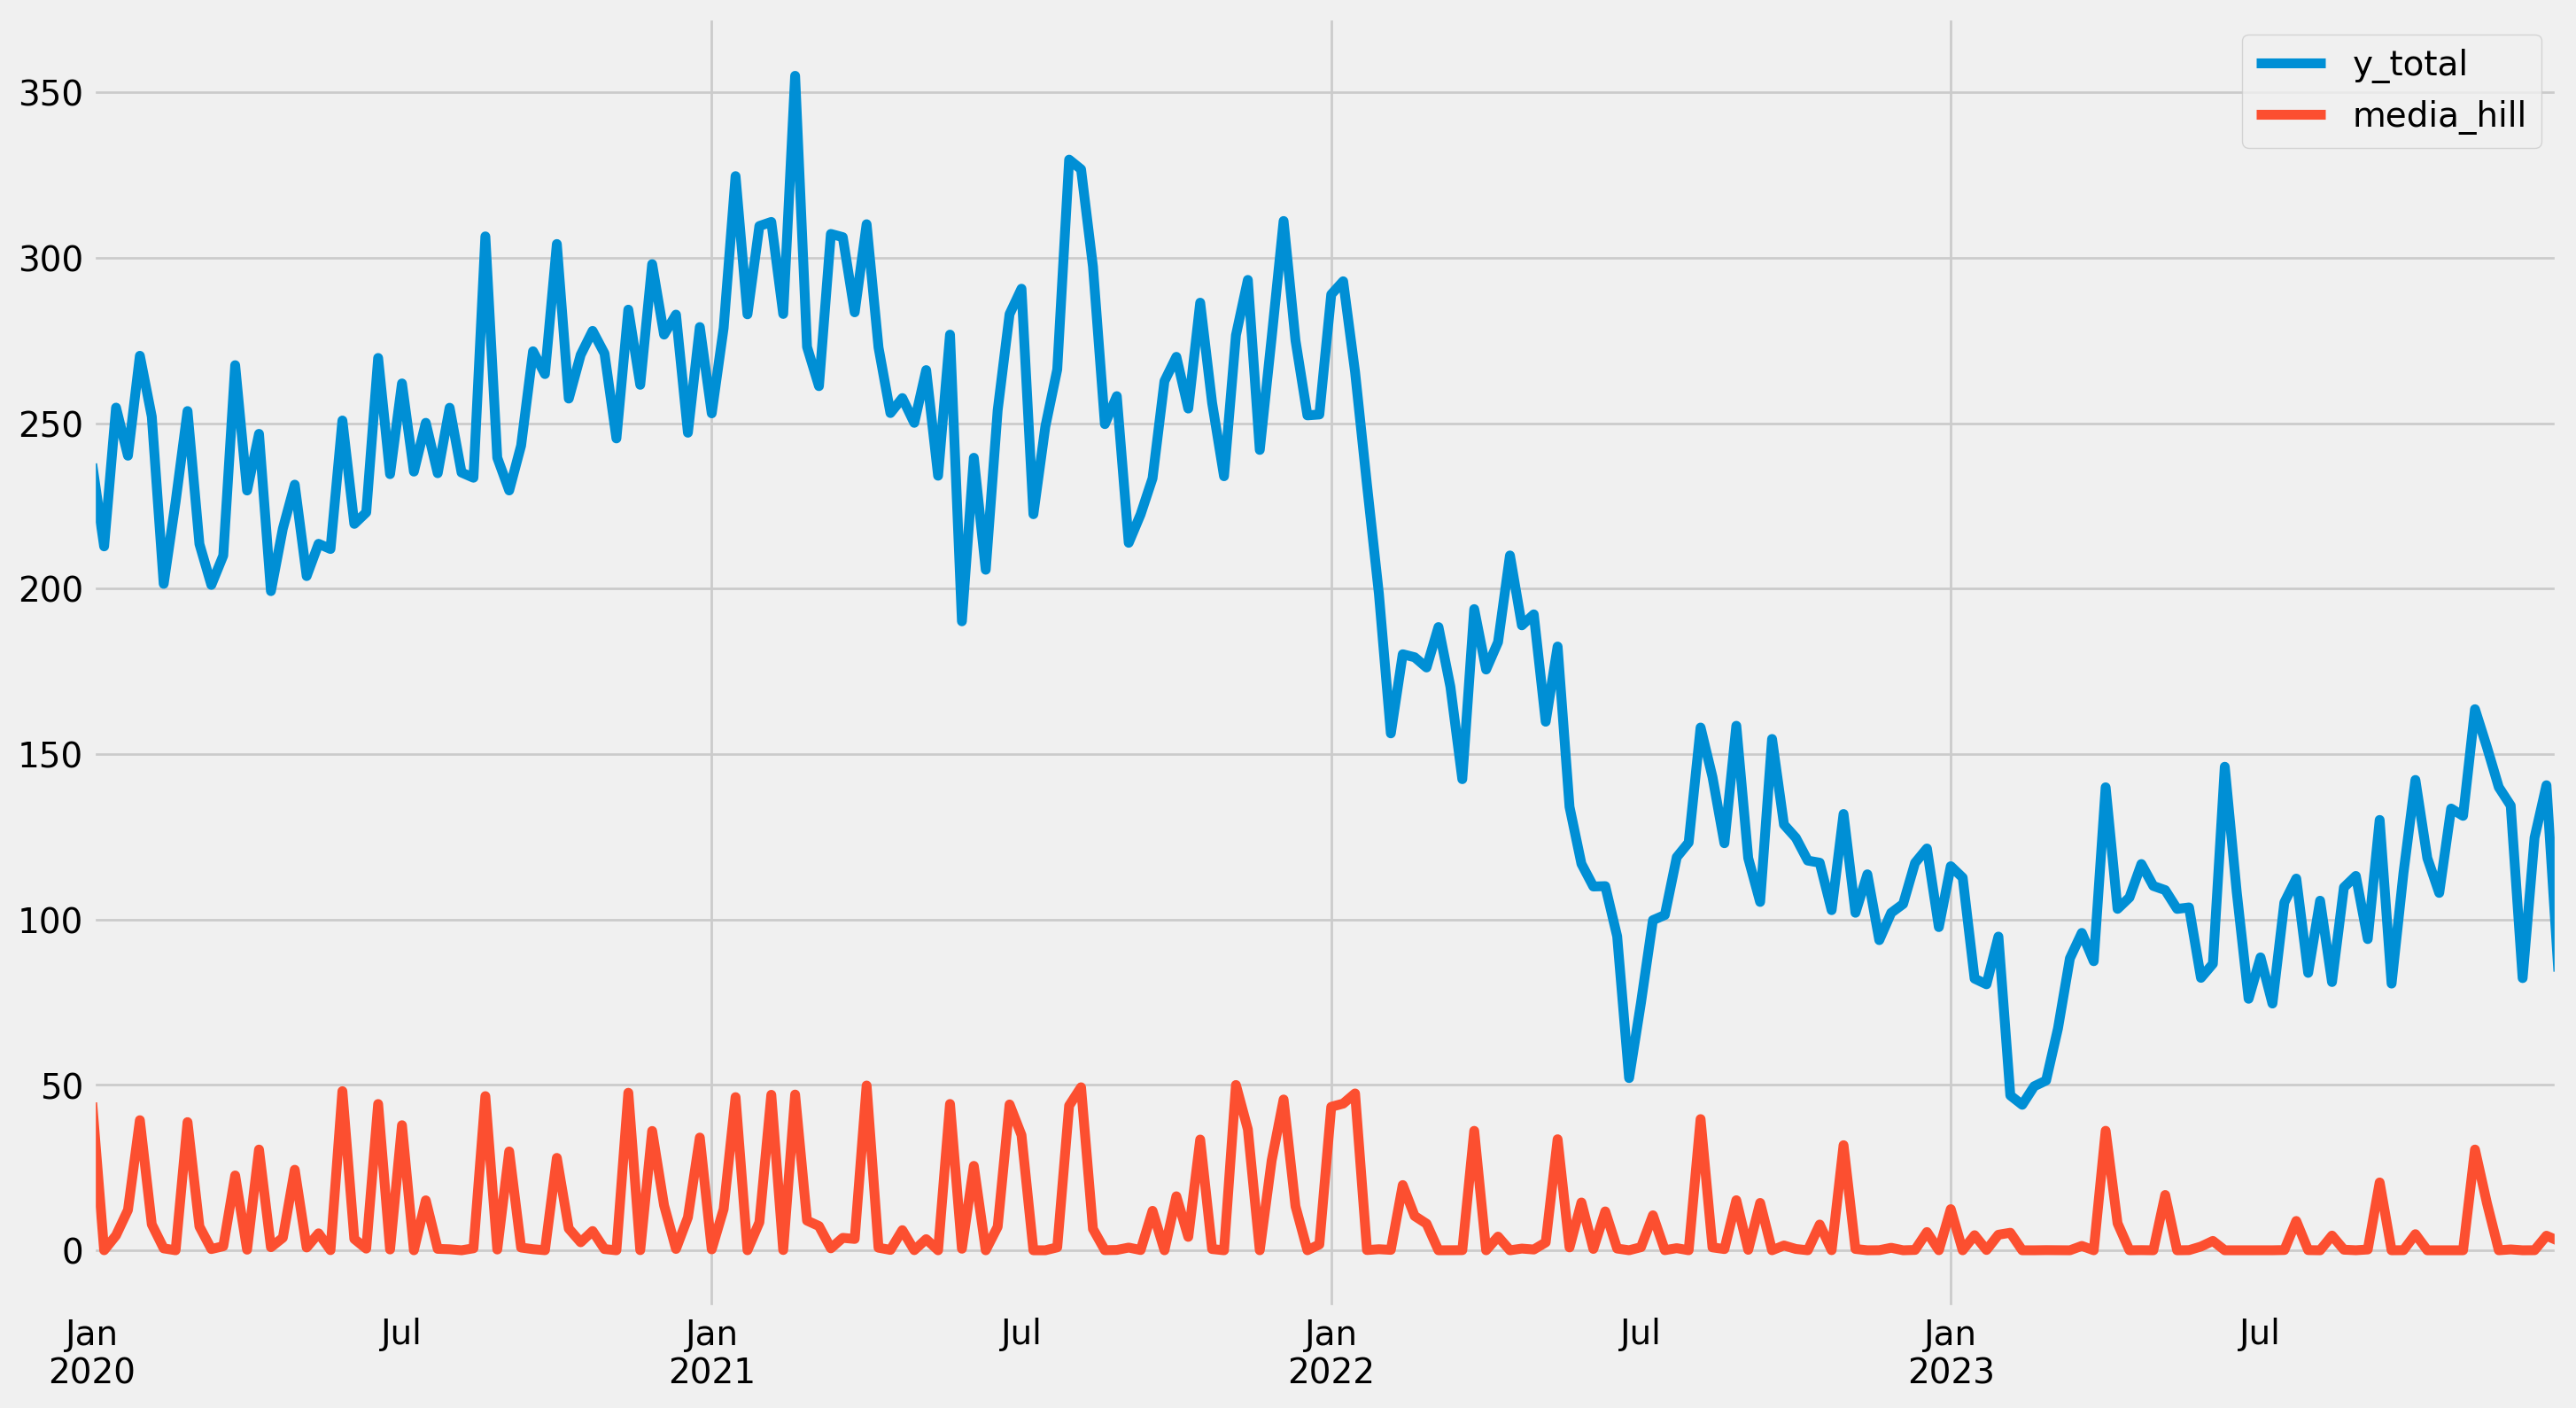

<Axes: xlabel='media', ylabel='media_hill'>

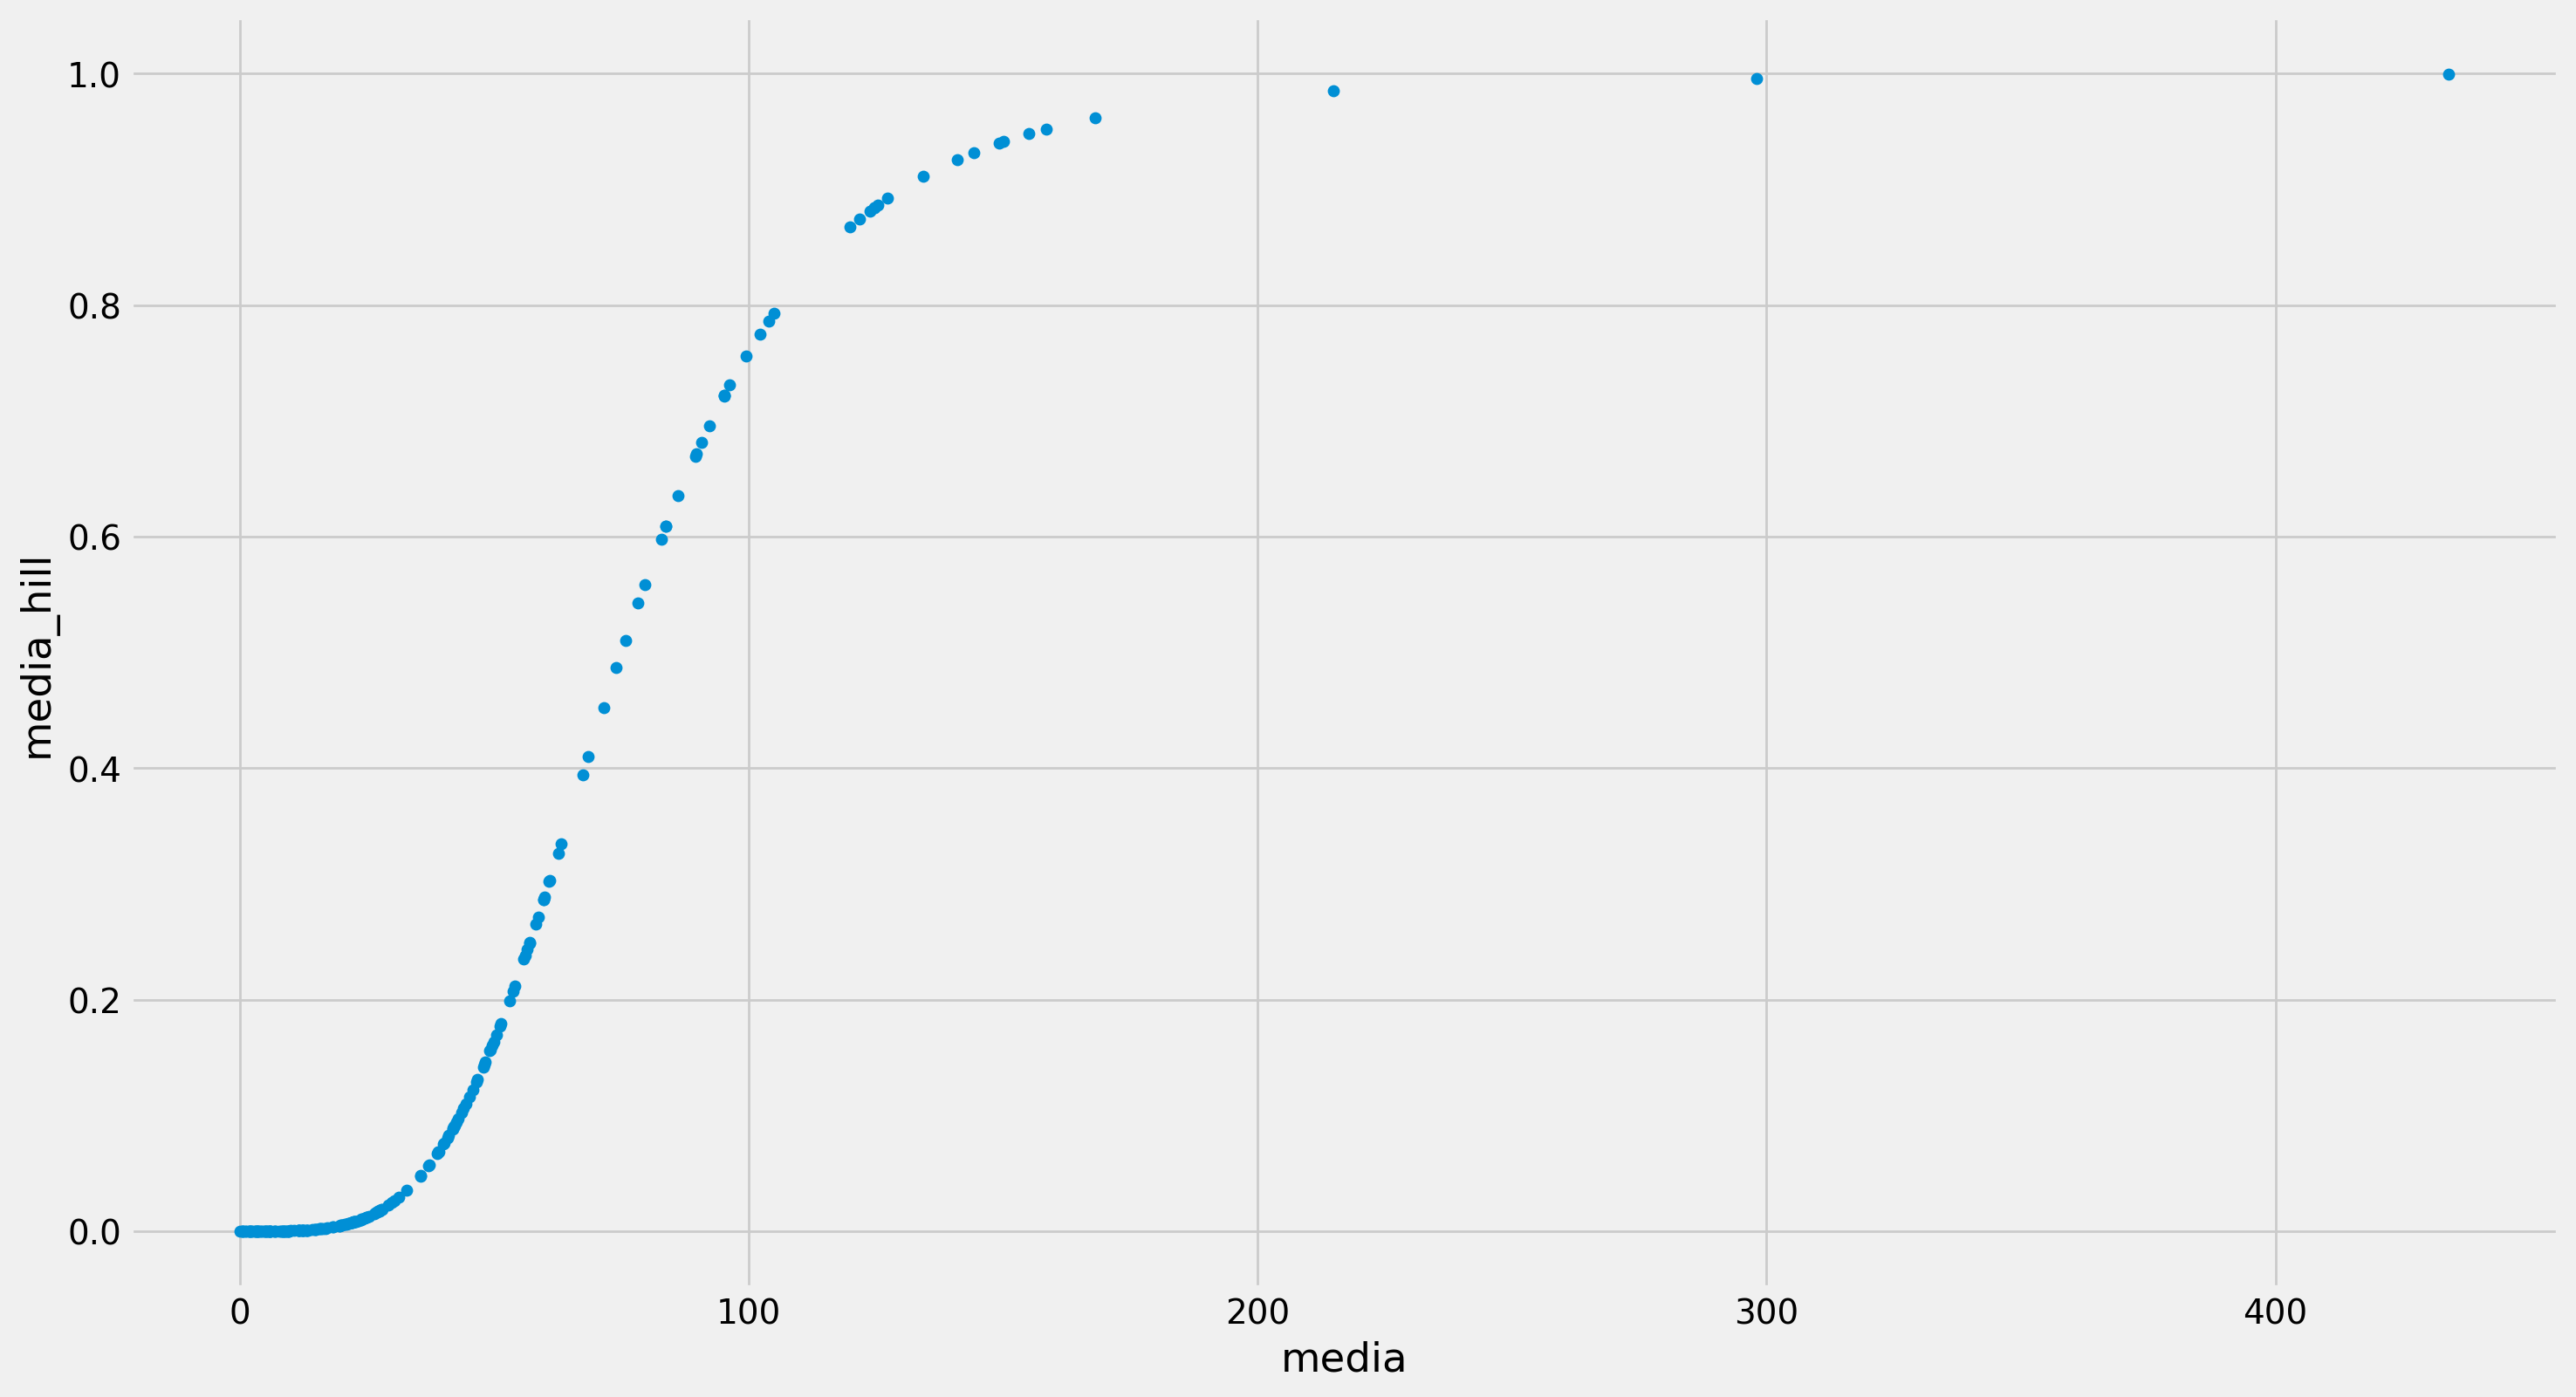

In [226]:
data['media'] = np.random.exponential(.5*data['x_causal'])

data['y_total'] = data['y'] + hill(data['media'], 75, 4)*50 + np.random.normal(0, 10, len(data))
data['media_hill'] = hill(data['media'], 75, 4)
data['competitive_media'] = .1*data['media'] + np.random.exponential(.5*data['x_spurious_0'])
data['industry_trend'] = data['y_total'] + 2*data['x_spurious_0'] + hill(data['competitive_media'], 75, 2)*60
data['y_total'].plot()
(data['media_hill']*50).plot()
plt.legend()
plt.show()
data.plot(x='media', y='media_hill', kind='scatter')

<Axes: >

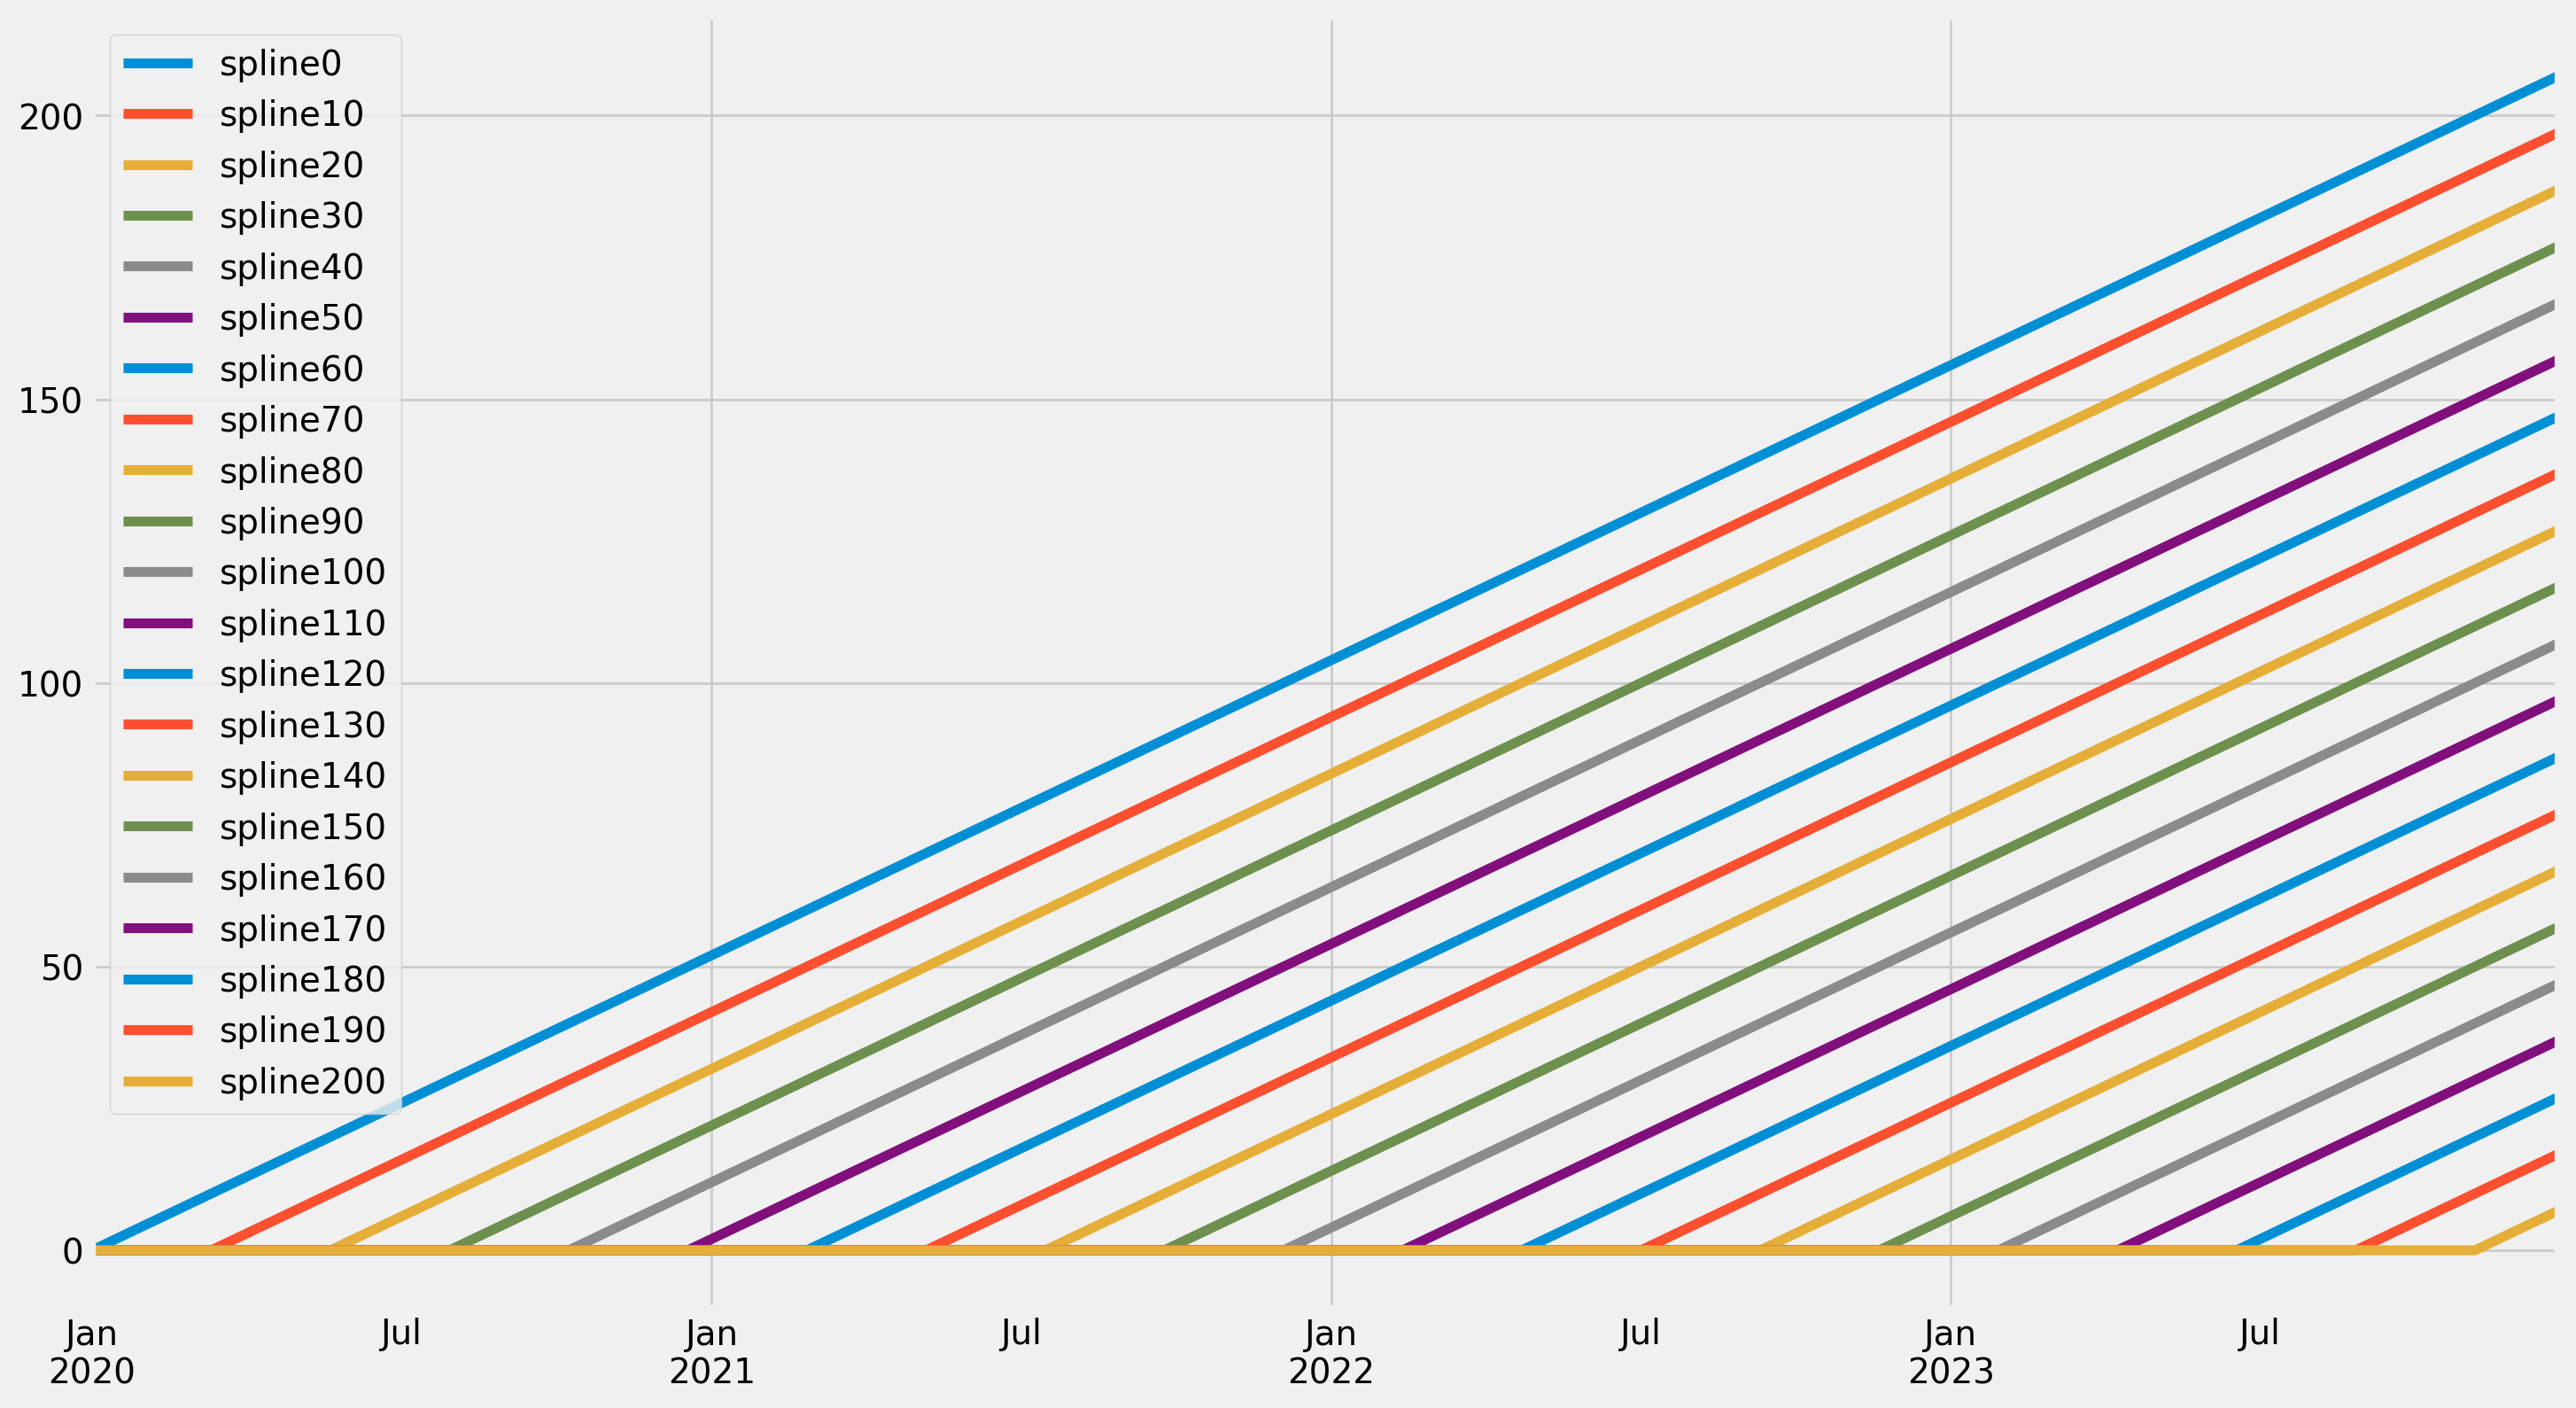

In [227]:
def make_spline(length, k, c=True):
  t = np.linspace(0, length-1, length)
  t[:k] = 0
  if c:
    t[k:] = 1
  else:
    t[k:] = t[k:]-t[k]
  return t
every_x = 10
data_spline = data.copy()
data_spline[[f'spline{k}' for k in range(0, len(data), every_x)]] = pd.DataFrame({f'spline{k}': make_spline(len(data), k, c=False) for k in range(0, len(data), every_x)}, index=data.index)
data_spline[[col for col in data_spline.columns if 'spline' in col]].plot()

In [228]:
#data.to_csv('simulated_data.csv')

In [229]:
split = 0.70
split_index = int(len(data_spline)*split)
train = data_spline.iloc[:split_index]
test = data_spline.iloc[split_index:]

In [230]:
splines_gt_0 = (train[[col for col in train.columns if 'spline' in col]]>0).sum(axis=0).sort_values(ascending=False)
splines = list(splines_gt_0[splines_gt_0>0].index)


In [231]:
ols_diff_model = sm.OLS(train['y_total'].diff(1).dropna(), sm.add_constant(train[['media_hill', 'x_causal']].diff(1).dropna())).fit()
ols_diff_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_total   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     141.2
Date:                Sun, 17 Mar 2024   Prob (F-statistic):           2.15e-34
Time:                        22:56:13   Log-Likelihood:                -623.23
No. Observations:                 144   AIC:                             1252.
Df Residuals:                     141   BIC:                             1261.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1523      1.548      0.098      0.922      -2.907       3.212
media_hill    48.7864      3.139     15.543      0.000      42.581      54.992
x_causal       2.1599      0.307      7.036      0.000       1.553       2.767
==============================================================================
Omnibus:                        0.662   Durbin-Watson:                   2.927
Prob(Omnibus):                  0.718   Jarque-Bera (JB):                0.751
Skew:                           0.000   Prob(JB):                        0.687
Kurtosis:                       2.646   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [232]:
spline_model = sm.OLS(train['y_total'], sm.add_constant(train[['media_hill']+splines])).fit()
spline_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_total   R-squared:                       0.913
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     83.88
Date:                Sun, 17 Mar 2024   Prob (F-statistic):           1.01e-59
Time:                        22:56:15   Log-Likelihood:                -622.51
No. Observations:                 145   AIC:                             1279.
Df Residuals:                     128   BIC:                             1330.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        223.0926     10.409     21.433      0.000     202.496     243.689
media_hill    48.6930      4.949      9.839      0.000      38.900      58.486
spline0       -0.4737      1.499     -0.316      0.752      -3.439       2.492
spline10      -0.4075      2.484     -0.164      0.870      -5.322       4.507
spline20       3.7583      2.262      1.661      0.099      -0.718       8.235
spline30      -0.4771      2.243     -0.213      0.832      -4.915       3.961
spline40      -3.1447      2.244     -1.401      0.164      -7.585       1.296
spline50       4.9105      2.244      2.188      0.030       0.470       9.350
spline60     -10.7302      2.243     -4.784      0.000     -15.169      -6.292
spline70       8.9315      2.253      3.965      0.000       4.474      13.389
spline80      -3.7773      2.260     -1.671      0.097      -8.250       0.695
spline90       4.0790      2.277      1.791      0.076      -0.427       8.585
spline100    -12.1289      2.285     -5.309      0.000     -16.649      -7.609
spline110     10.2187      2.248      4.545      0.000       5.770      14.668
spline120    -11.1090      2.252     -4.933      0.000     -15.565      -6.653
spline130     16.8022      2.386      7.043      0.000      12.082      21.523
spline140    -11.7376      5.559     -2.111      0.037     -22.737      -0.738
==============================================================================
Omnibus:                        4.703   Durbin-Watson:                   1.411
Prob(Omnibus):                  0.095   Jarque-Bera (JB):                4.260
Skew:                          -0.406   Prob(JB):                        0.119
Kurtosis:                       3.217   Cond. No.                     1.14e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

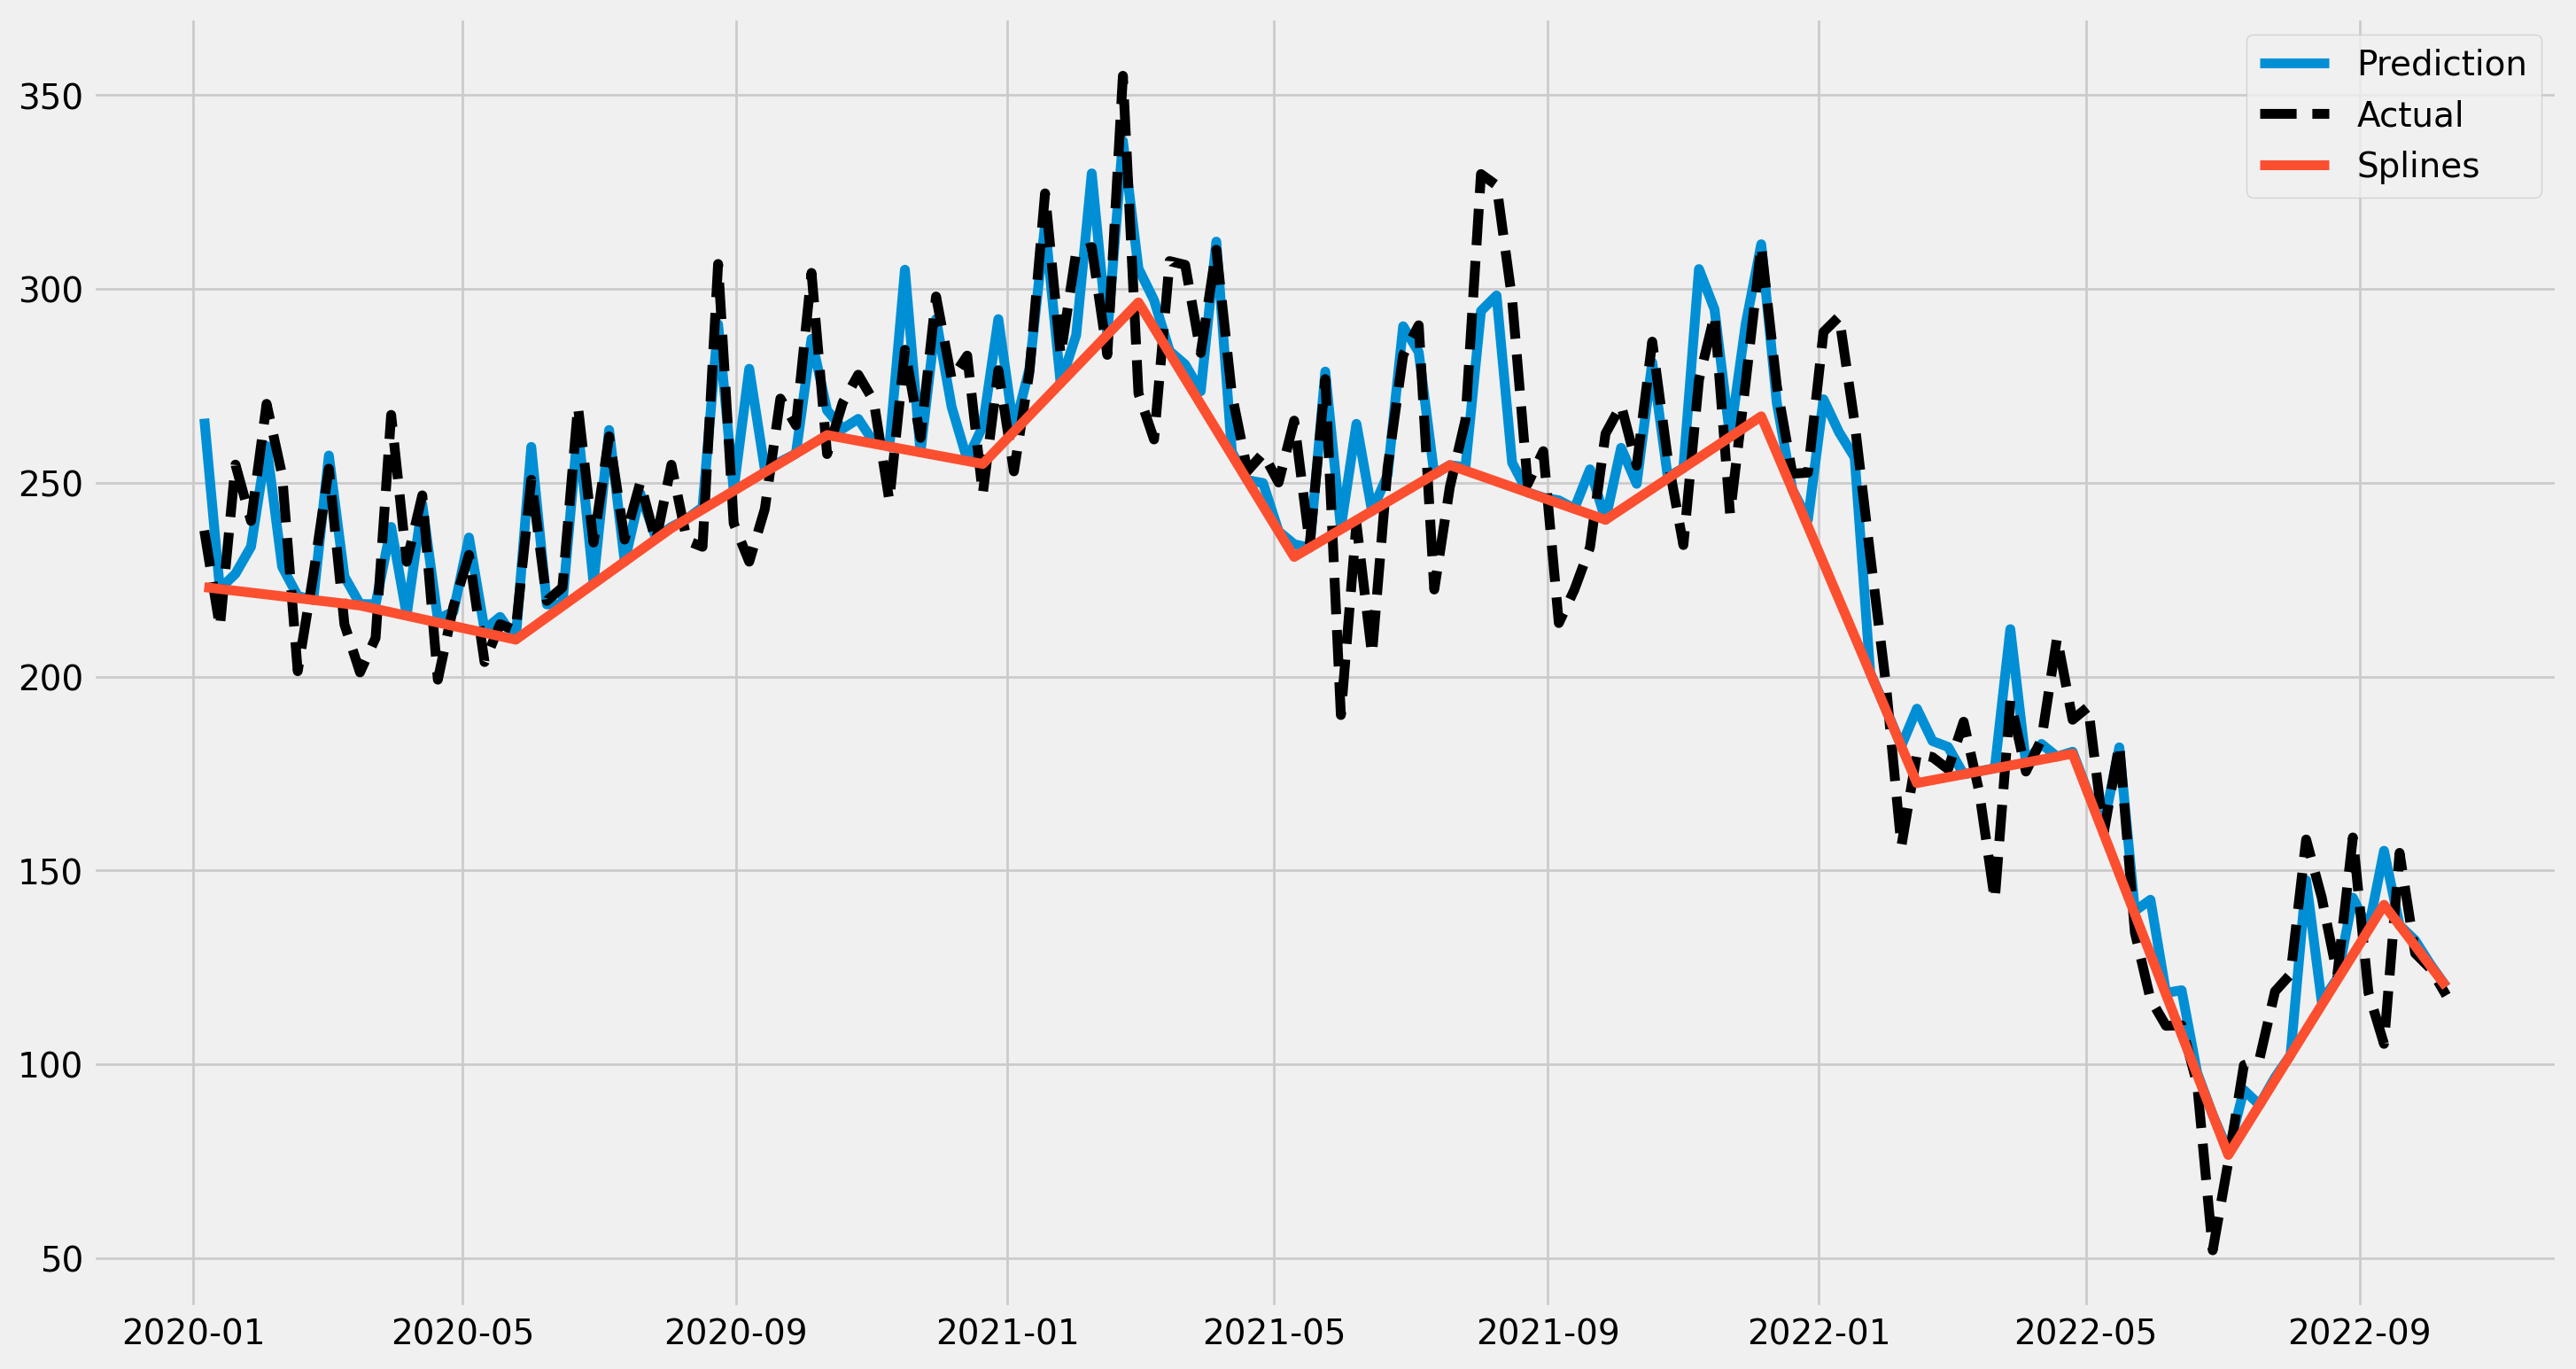

In [233]:
plt.plot(train.index, spline_model.predict(), label='Prediction', c='C0')
plt.plot(train.index, train['y_total'], label='Actual', ls='--', c='k')
fake_train = train.copy()
fake_train['media_hill'] = 0
plt.plot(train.index, spline_model.predict(sm.add_constant(fake_train[['media_hill']+splines])), label='Splines', c='C1')
plt.legend()

In [234]:
ols_model = sm.OLS(train['y_total'], sm.add_constant(train[['x_causal', 'media_hill']])).fit()
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_total   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     1239.
Date:                Sun, 17 Mar 2024   Prob (F-statistic):           1.28e-90
Time:                        22:56:19   Log-Likelihood:                -588.12
No. Observations:                 145   AIC:                             1182.
Df Residuals:                     142   BIC:                             1191.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6397      4.878      0.746      0.457      -6.003      13.282
x_causal       1.9666      0.044     44.296      0.000       1.879       2.054
media_hill    49.3082      3.579     13.776      0.000      42.233      56.384
==============================================================================
Omnibus:                        6.886   Durbin-Watson:                   1.716
Prob(Omnibus):                  0.032   Jarque-Bera (JB):                6.562
Skew:                          -0.447   Prob(JB):                       0.0376
Kurtosis:                       3.536   Cond. No.                         466.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [235]:
ols_diff_model = sm.OLS(train['y_total'].diff(1).dropna(), sm.add_constant(train[['media_hill']].diff(1).dropna())).fit()
ols_diff_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_total   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     173.6
Date:                Sun, 17 Mar 2024   Prob (F-statistic):           2.10e-26
Time:                        22:56:20   Log-Likelihood:                -644.89
No. Observations:                 144   AIC:                             1294.
Df Residuals:                     142   BIC:                             1300.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.5361      1.789     -0.300      0.765      -4.073       3.000
media_hill    47.8640      3.632     13.177      0.000      40.683      55.045
==============================================================================
Omnibus:                        0.080   Durbin-Watson:                   2.502
Prob(Omnibus):                  0.961   Jarque-Bera (JB):                0.048
Skew:                          -0.041   Prob(JB):                        0.976
Kurtosis:                       2.966   Cond. No.                         2.03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [236]:
ols_model_hill = sm.OLS(train['y_total'], sm.add_constant(train[['media_hill']])).fit()
ols_model_hill.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_total   R-squared:                       0.197
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     35.10
Date:                Sun, 17 Mar 2024   Prob (F-statistic):           2.23e-08
Time:                        22:56:21   Log-Likelihood:                -783.57
No. Observations:                 145   AIC:                             1571.
Df Residuals:                     143   BIC:                             1577.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        209.9243      5.567     37.709      0.000     198.920     220.928
media_hill    79.8196     13.473      5.924      0.000      53.188     106.452
==============================================================================
Omnibus:                       15.156   Durbin-Watson:                   0.241
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.364
Skew:                          -0.847   Prob(JB):                     0.000170
Kurtosis:                       3.068   Cond. No.                         3.19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [237]:
ols_model_sp = sm.OLS(train['y_total'], sm.add_constant(train[["media_hill"]+[spur for spur in train.columns if 'spurious' in spur]])).fit()
ols_model_sp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_total   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     71.69
Date:                Sun, 17 Mar 2024   Prob (F-statistic):           2.28e-50
Time:                        22:56:27   Log-Likelihood:                -659.14
No. Observations:                 145   AIC:                             1342.
Df Residuals:                     133   BIC:                             1378.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -63.8930     90.425     -0.707      0.481    -242.749     114.963
media_hill      54.7052      6.055      9.035      0.000      42.730      66.681
x_spurious_0     0.8736      0.273      3.206      0.002       0.335       1.413
x_spurious_1    -0.0458      0.176     -0.260      0.795      -0.394       0.302
x_spurious_2     1.6449      0.250      6.579      0.000       1.150       2.139
x_spurious_3     0.1816      0.265      0.686      0.494      -0.342       0.705
x_spurious_4    -0.8419      0.251     -3.353      0.001      -1.339      -0.345
x_spurious_5    -1.0287      0.243     -4.228      0.000      -1.510      -0.547
x_spurious_6     1.0758      0.147      7.319      0.000       0.785       1.367
x_spurious_7    -0.0858      0.221     -0.388      0.698      -0.523       0.351
x_spurious_8     1.4769      0.177      8.329      0.000       1.126       1.828
x_spurious_9    -0.3456      0.217     -1.595      0.113      -0.774       0.083
==============================================================================
Omnibus:                        0.131   Durbin-Watson:                   1.111
Prob(Omnibus):                  0.937   Jarque-Bera (JB):                0.009
Skew:                          -0.010   Prob(JB):                        0.996
Kurtosis:                       3.032   Cond. No.                     1.70e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.7e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [263]:
colider_model_sp = sm.OLS(train['y_total'], sm.add_constant(train[["media_hill", 'industry_trend', 'x_causal']])).fit()
colider_model_sp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                y_total   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     976.3
Date:                Sun, 17 Mar 2024   Prob (F-statistic):           4.44e-94
Time:                        23:13:48   Log-Likelihood:                -576.14
No. Observations:                 145   AIC:                             1160.
Df Residuals:                     141   BIC:                             1172.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            -48.2565     11.251     -4.289      0.000     -70.499     -26.014
media_hill        39.6080      3.827     10.348      0.000      32.041      47.175
industry_trend     0.1601      0.032      5.034      0.000       0.097       0.223
x_causal           1.7007      0.067     25.434      0.000       1.569       1.833
==============================================================================
Omnibus:                        2.778   Durbin-Watson:                   1.628
Prob(Omnibus):                  0.249   Jarque-Bera (JB):                2.332
Skew:                          -0.294   Prob(JB):                        0.312
Kurtosis:                       3.200   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

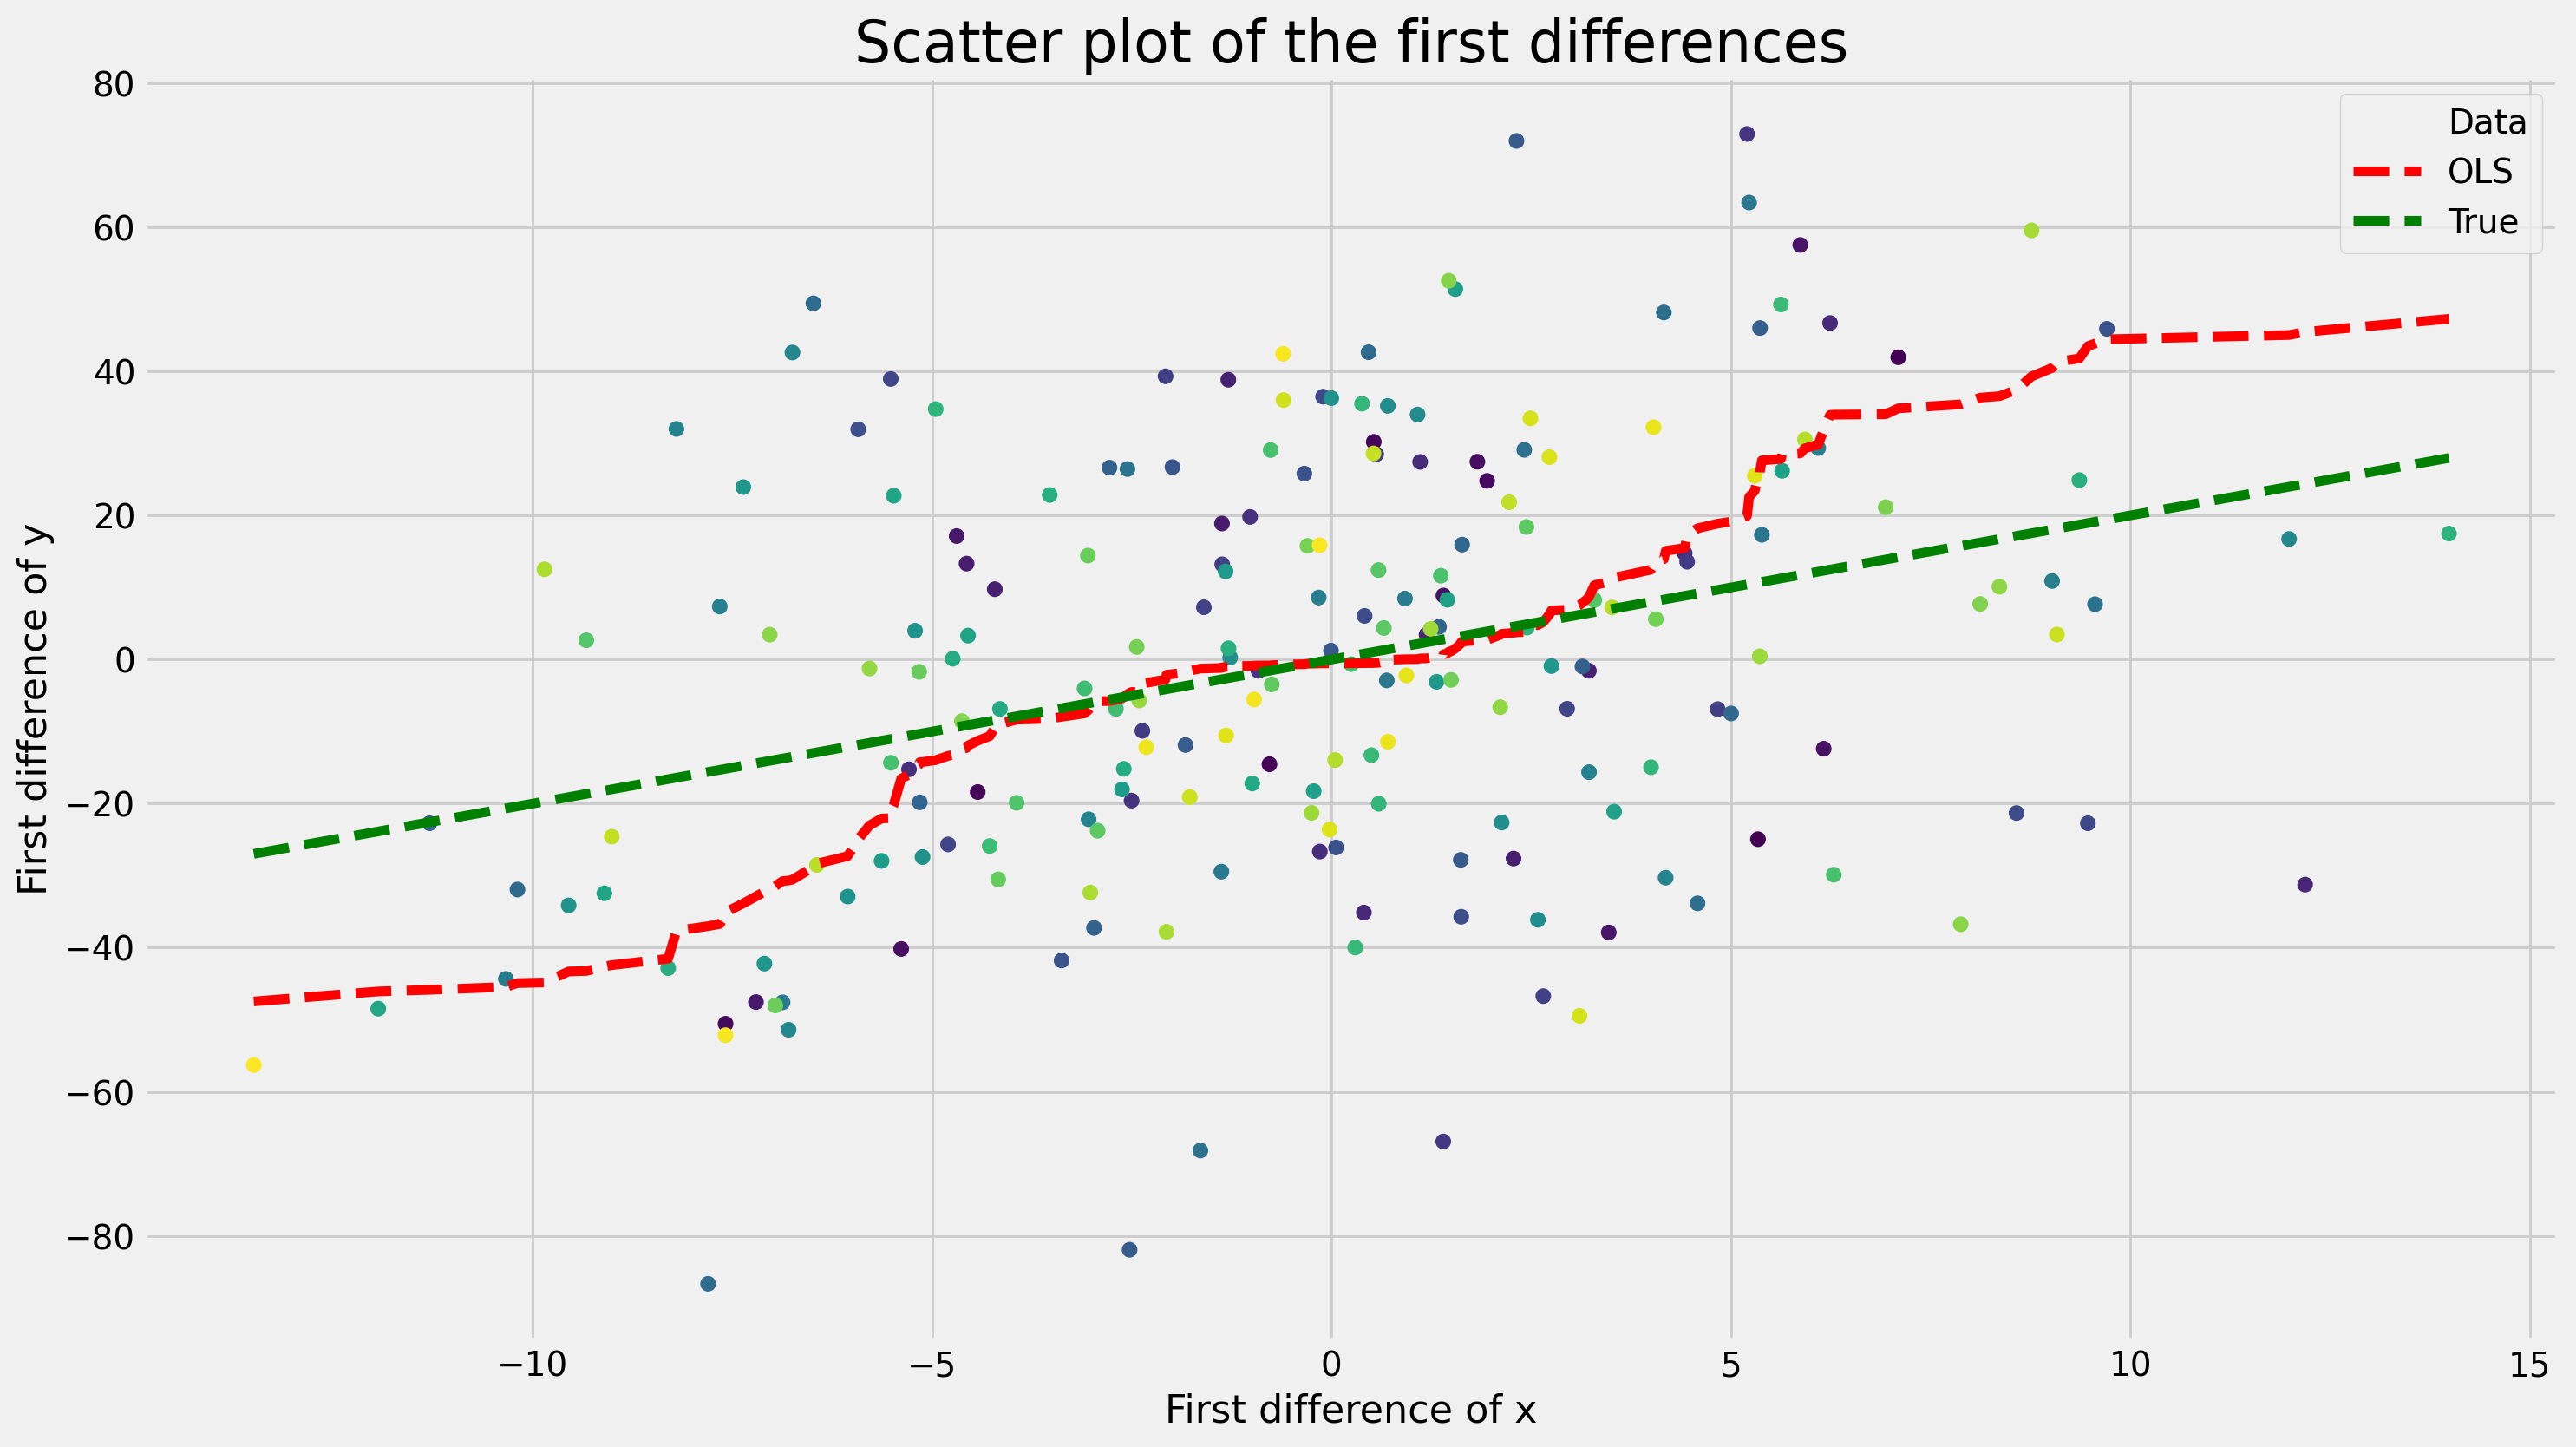

In [239]:
plt.scatter(data['x_causal'].diff(1), data['y_total'].diff(1), label='Data', c=data.index)
plt.title('Scatter plot of the first differences', fontdict={'fontsize': 24})
plt.xlabel('First difference of x', fontdict={'fontsize': 16})
plt.ylabel('First difference of y', fontdict={'fontsize': 16})
plt.plot(data[['x_causal']].diff().sort_values(by='x_causal').dropna(), 
         ols_diff_model.predict(
           sm.add_constant(
             data[['media_hill']].diff().sort_values('media_hill').dropna())),
         'r', ls='--', label='OLS')
plt.plot(data[['x_causal']].diff().sort_values(by='x_causal').dropna(),
          2*data[['x_causal']].diff().sort_values(by='x_causal').dropna(), 'g', ls='--', label='True')
plt.legend()
plt.show()



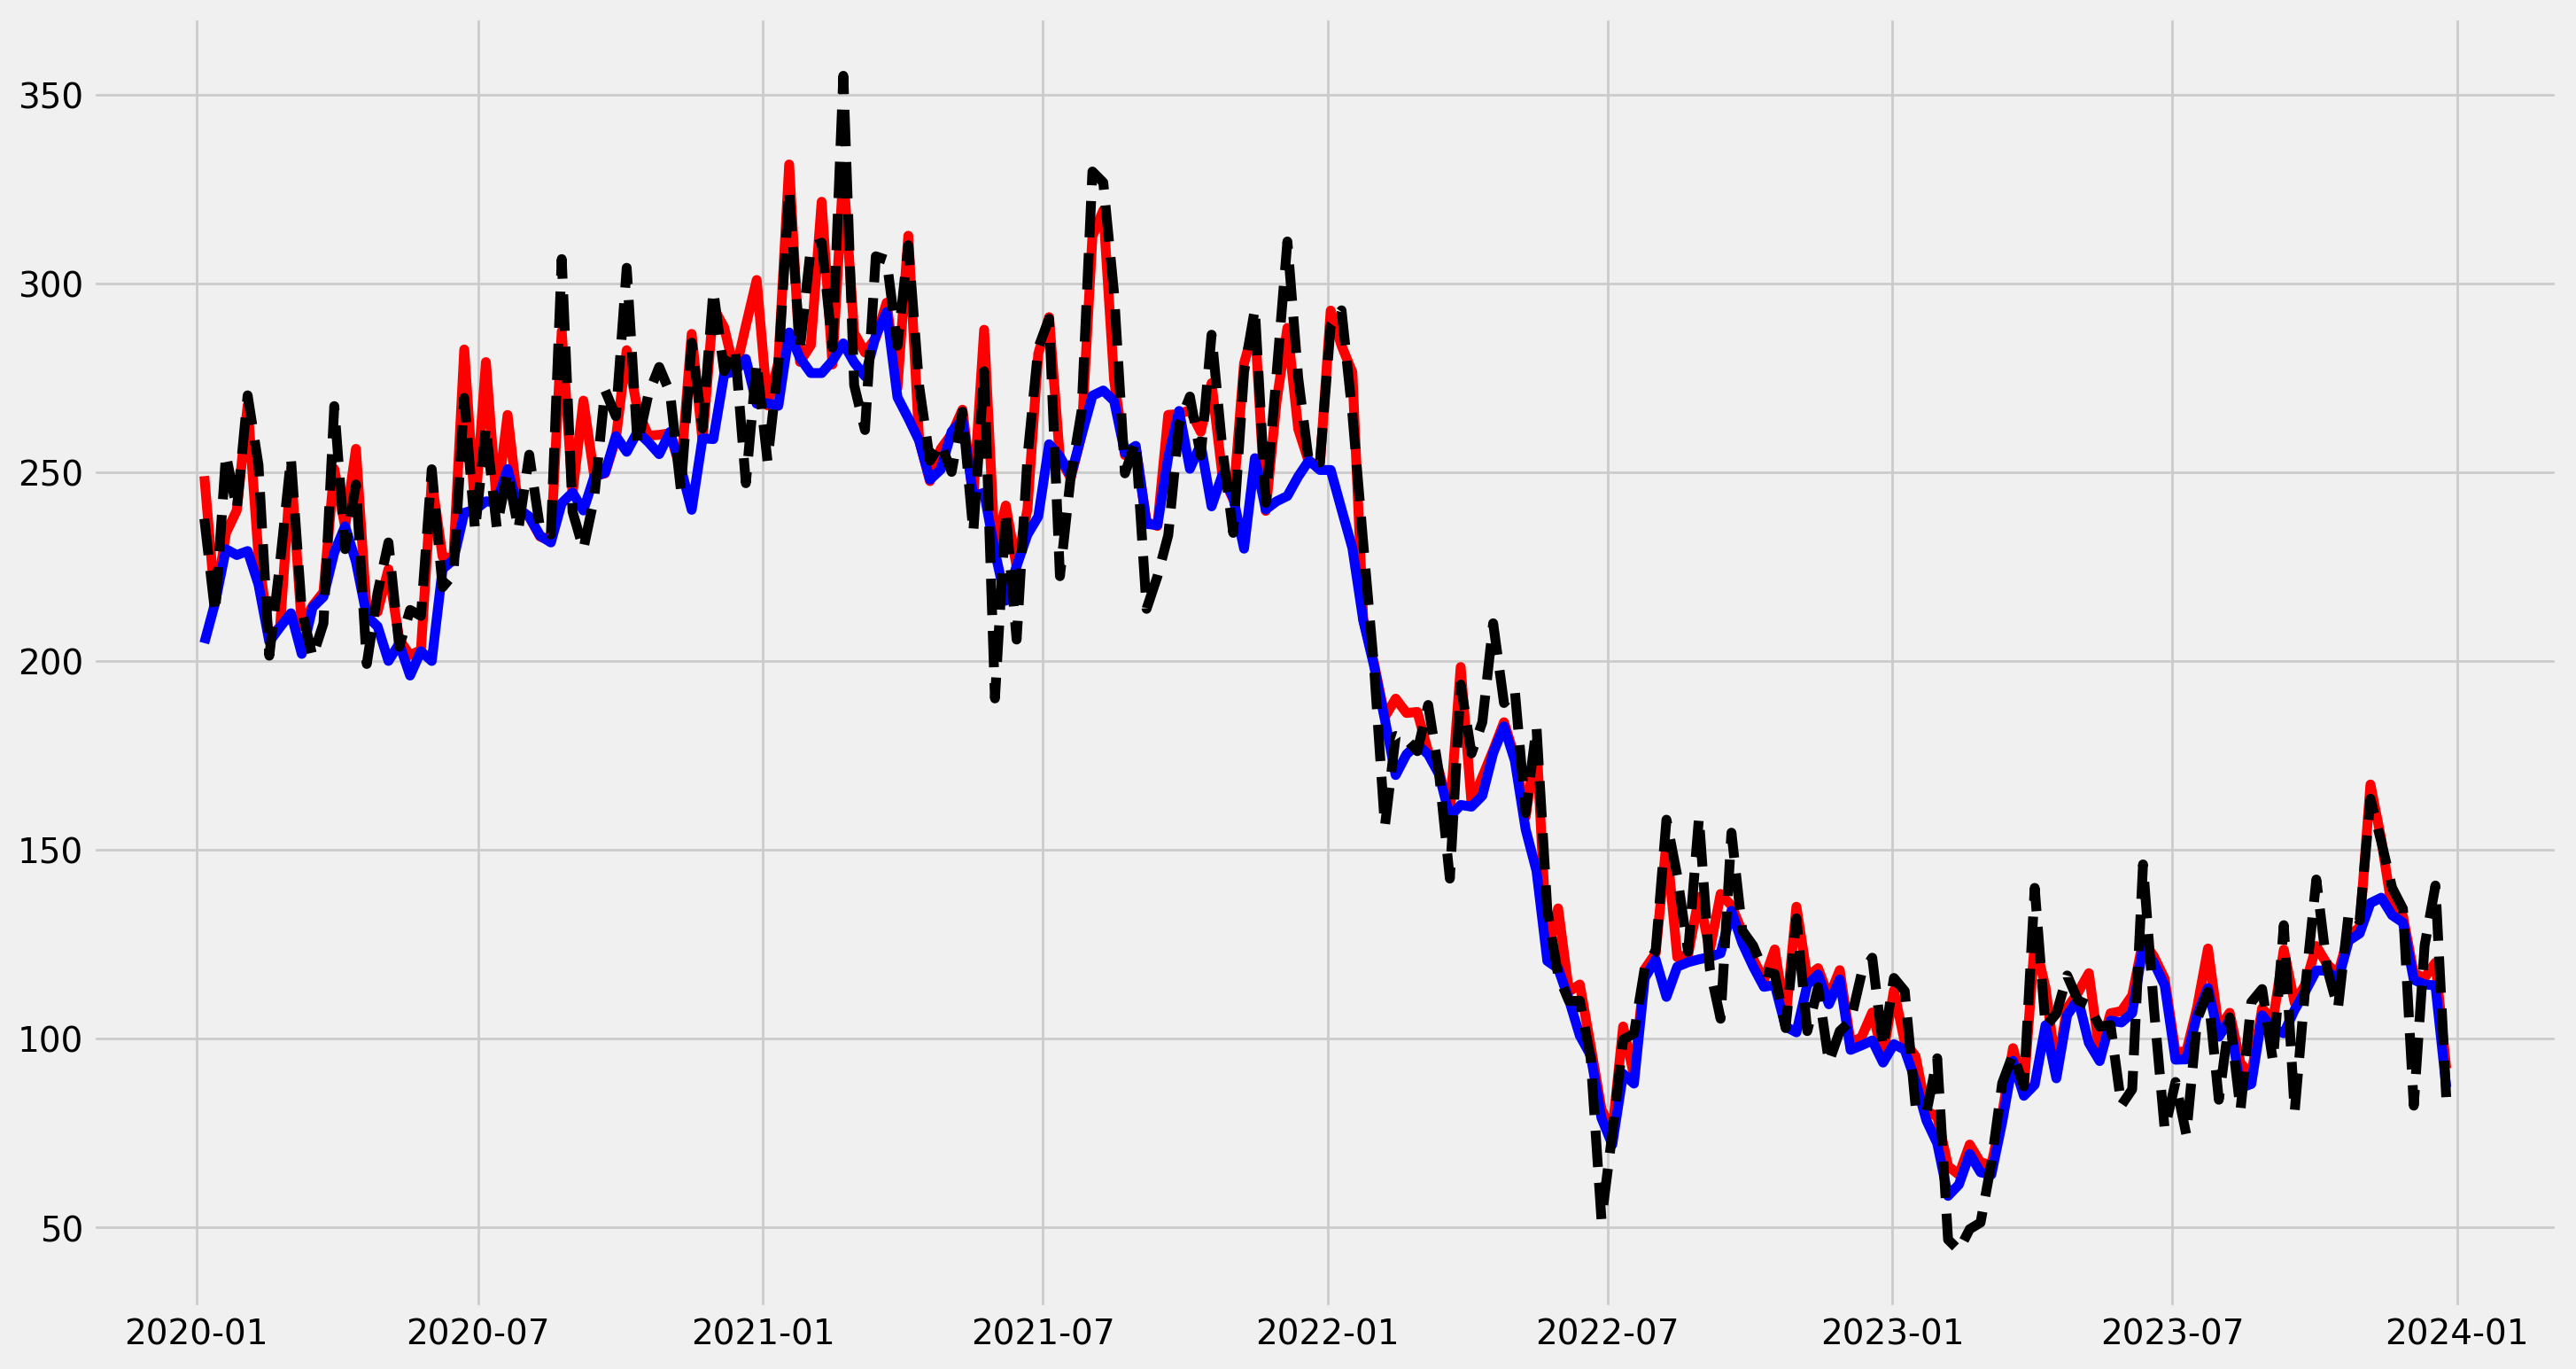

In [240]:
plt.plot(data.index, ols_model.predict(sm.add_constant(data[['x_causal', 'media_hill']])),'r', label='OLS')
plt.plot(data.index, data['x_causal']*2, label='Long Run', c='b')
plt.plot(data.index, data['y_total'], label='Data', c='k', ls='--')

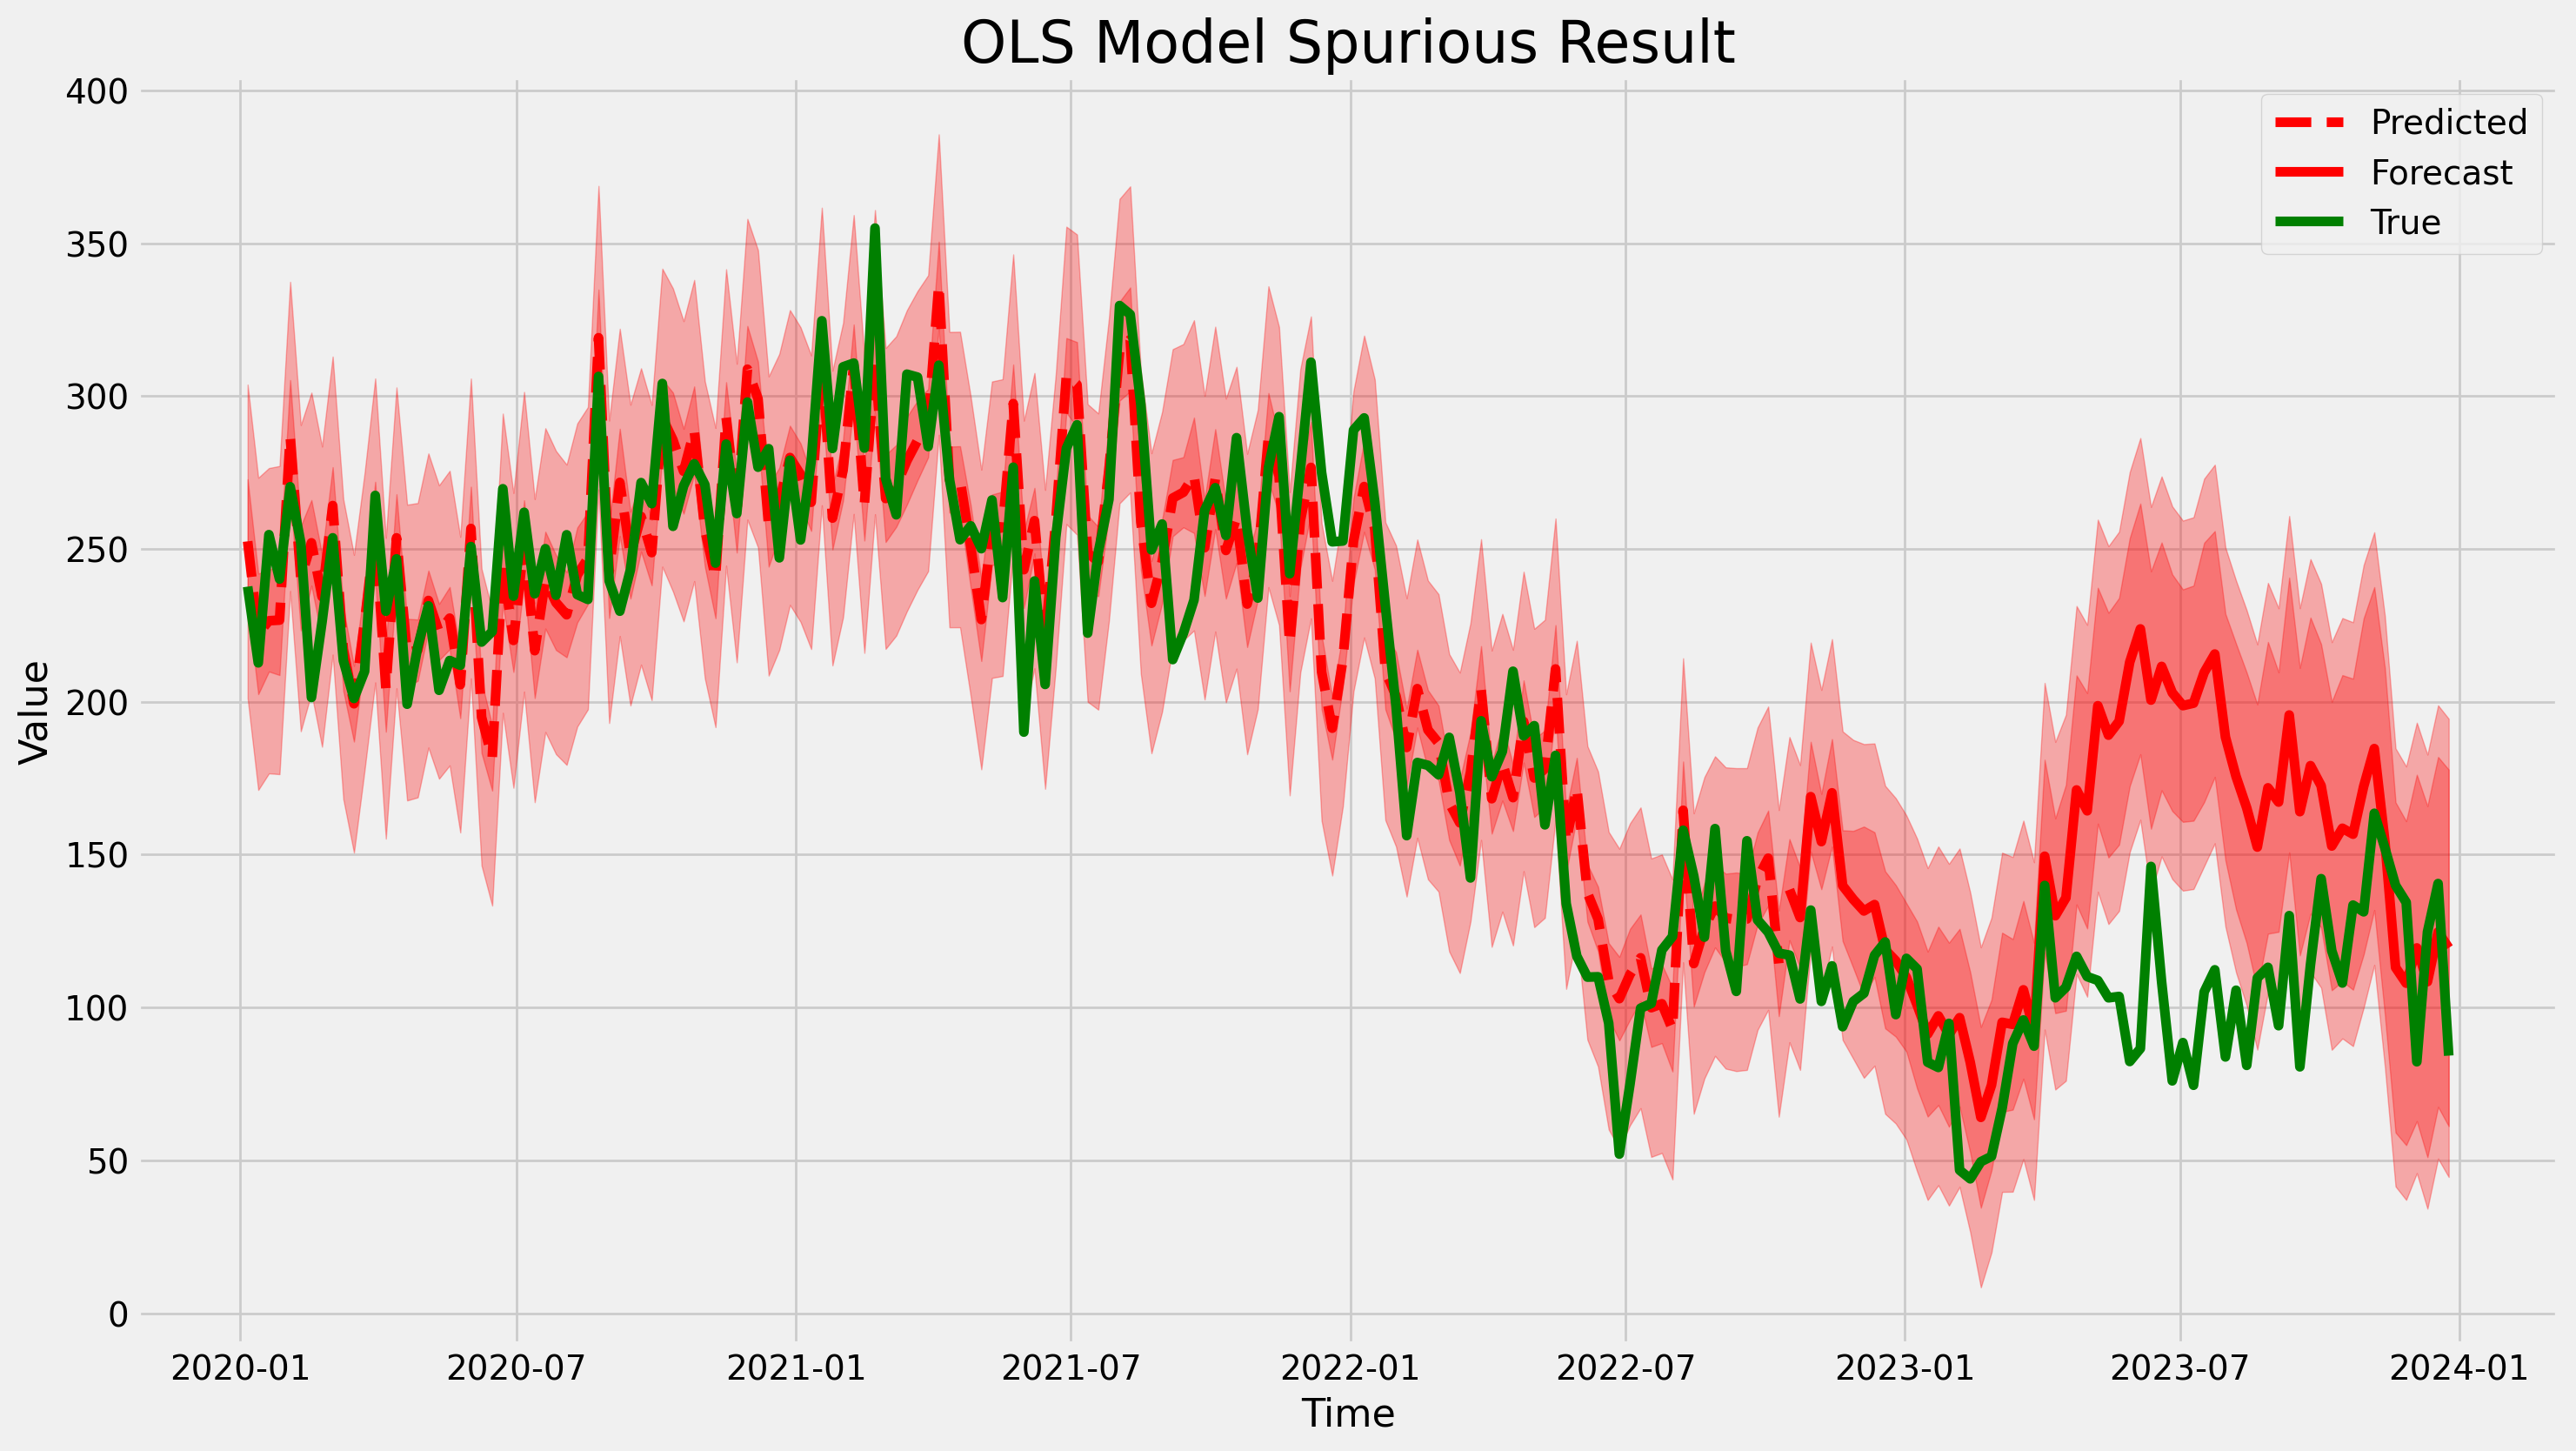

In [241]:
spurious_model_prediction = ols_model_sp.get_prediction(sm.add_constant(data[["media_hill"]+[spur for spur in train.columns if 'spurious' in spur]])).summary_frame()

plt.plot(data.iloc[:split_index].index, spurious_model_prediction['mean'].iloc[:split_index], 'r', ls='--', label='Predicted')
plt.fill_between(data.index, spurious_model_prediction['obs_ci_lower'], spurious_model_prediction['obs_ci_upper'], color='r', alpha=0.3)
plt.fill_between(data.index, spurious_model_prediction['mean_ci_lower'], spurious_model_prediction['mean_ci_upper'], color='r', alpha=0.3)
plt.plot(data.iloc[split_index:].index, spurious_model_prediction['mean'].iloc[split_index:], label='Forecast', c='r')
plt.plot(data.index, data['y_total'], label='True', c='g')
plt.legend()
plt.title('OLS Model Spurious Result', fontdict={'fontsize': 24})
plt.xlabel('Time', fontdict={'fontsize': 16})
plt.ylabel('Value', fontdict={'fontsize': 16})
plt.show()

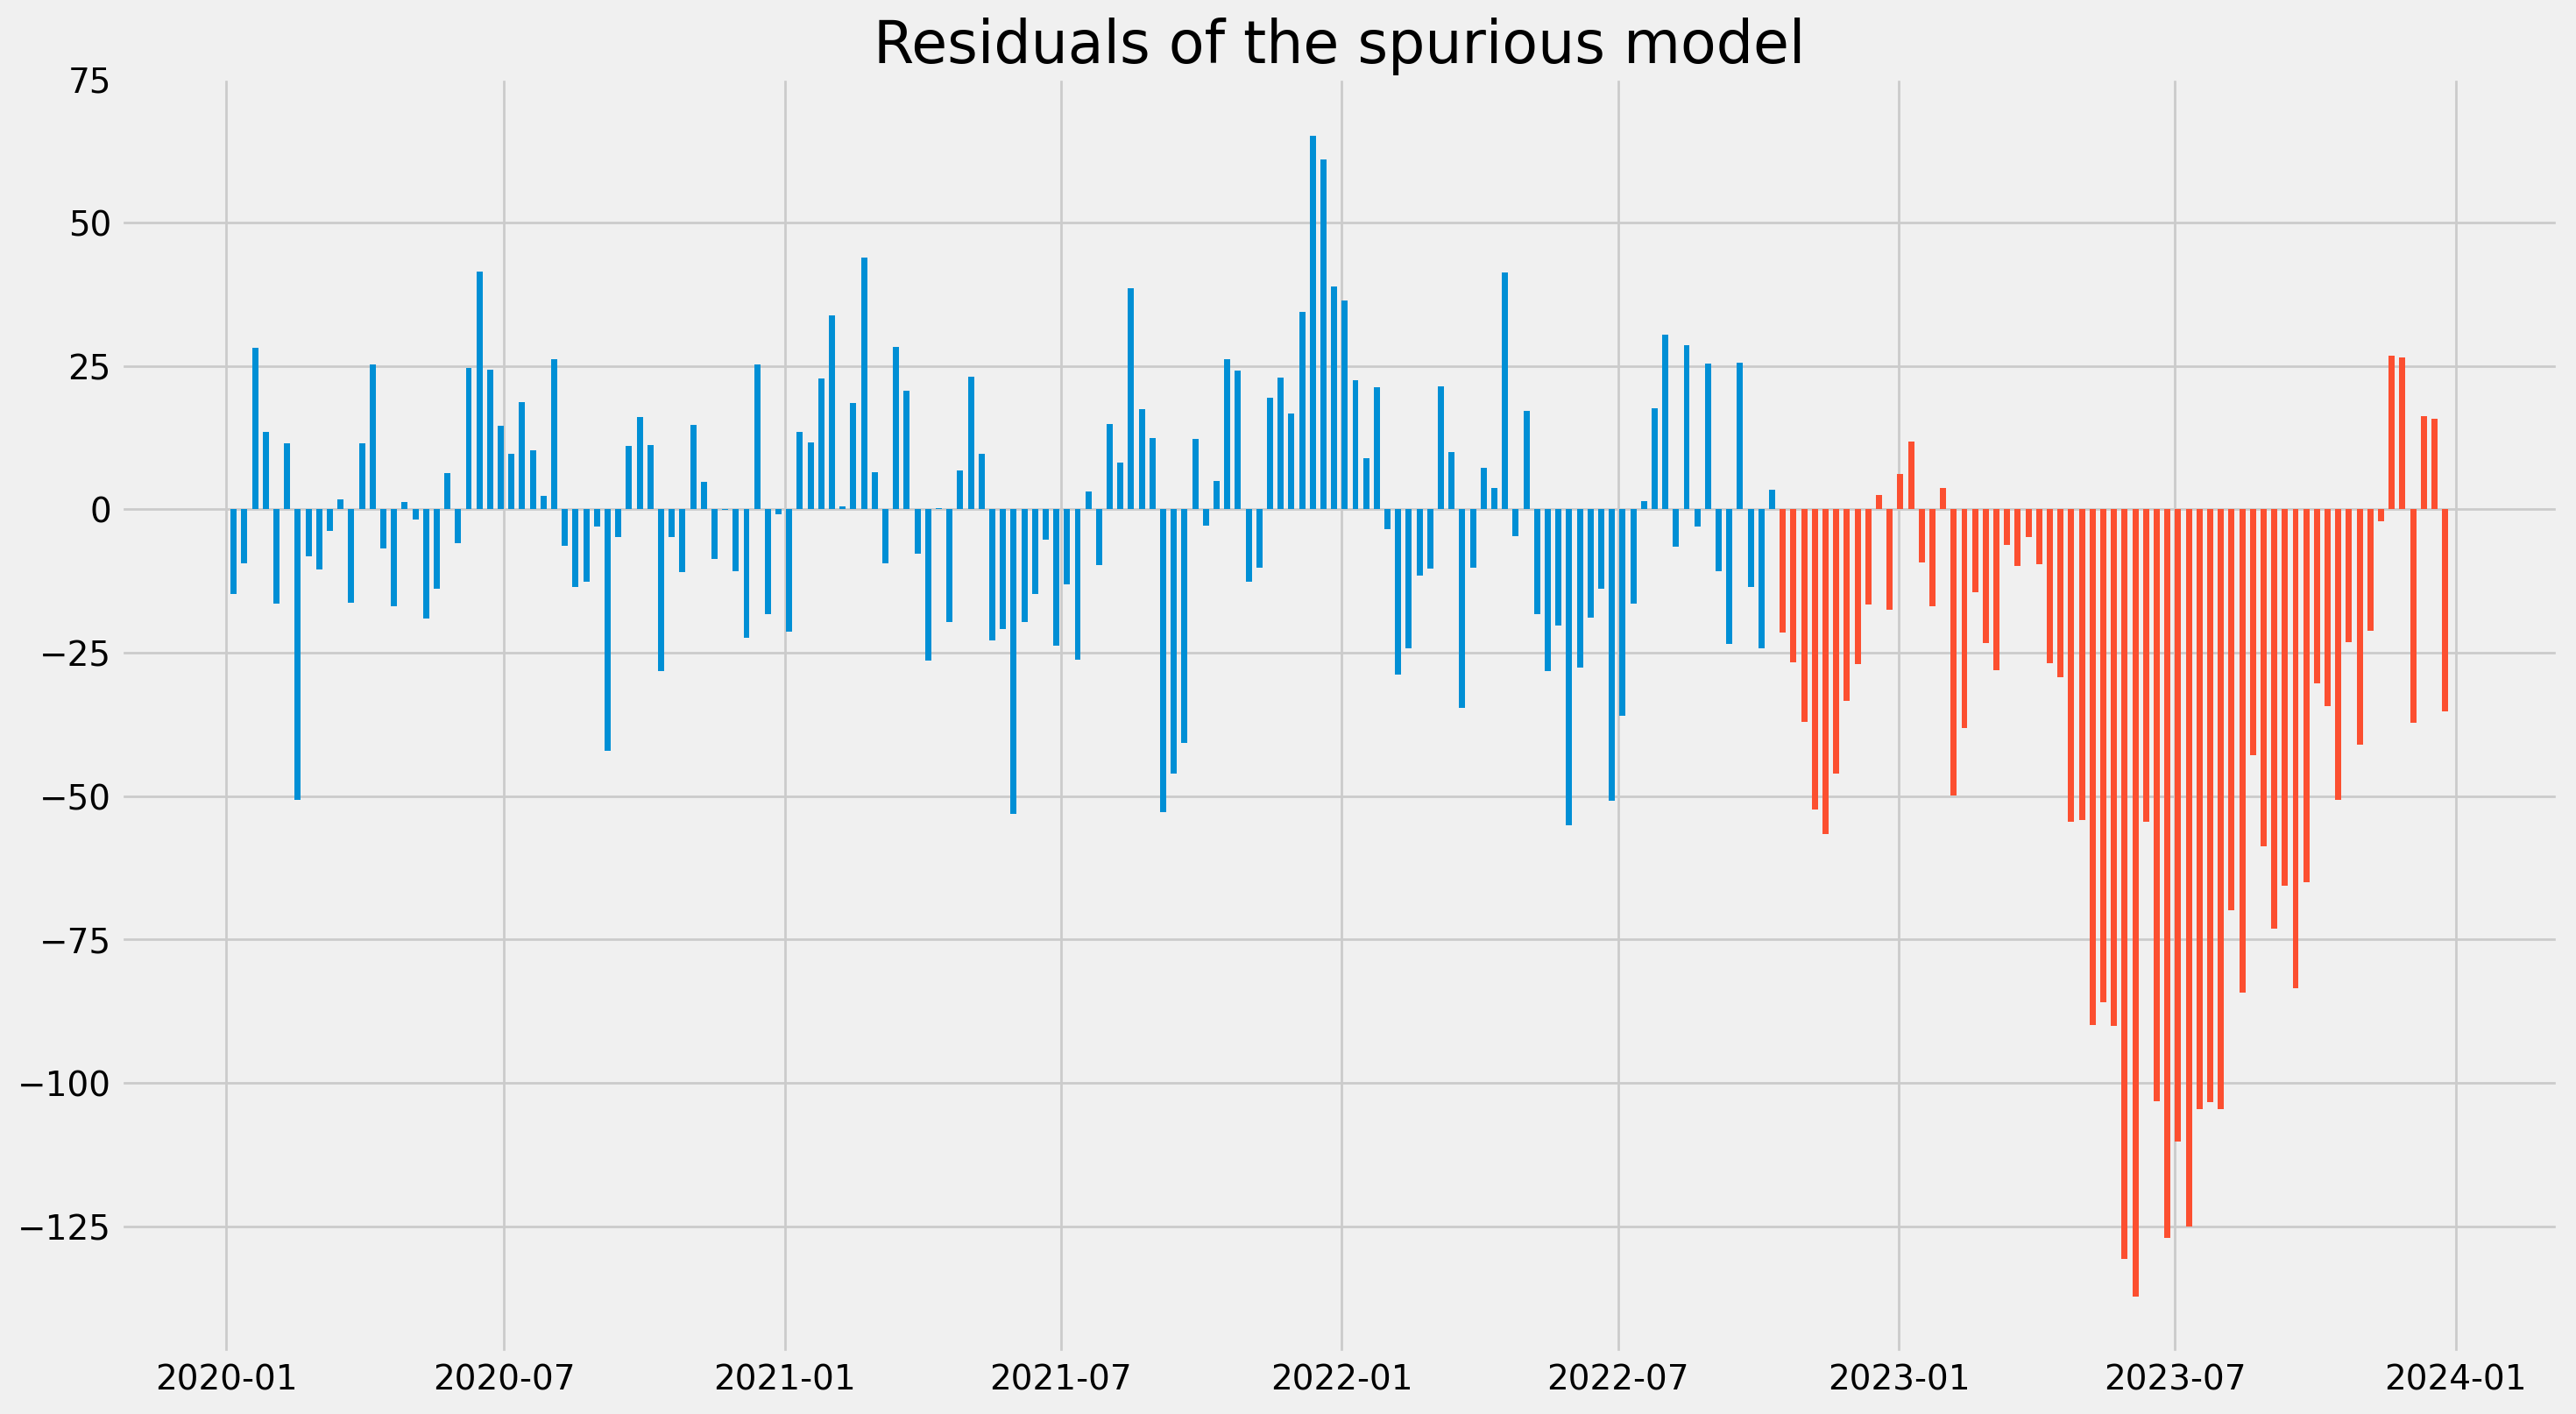

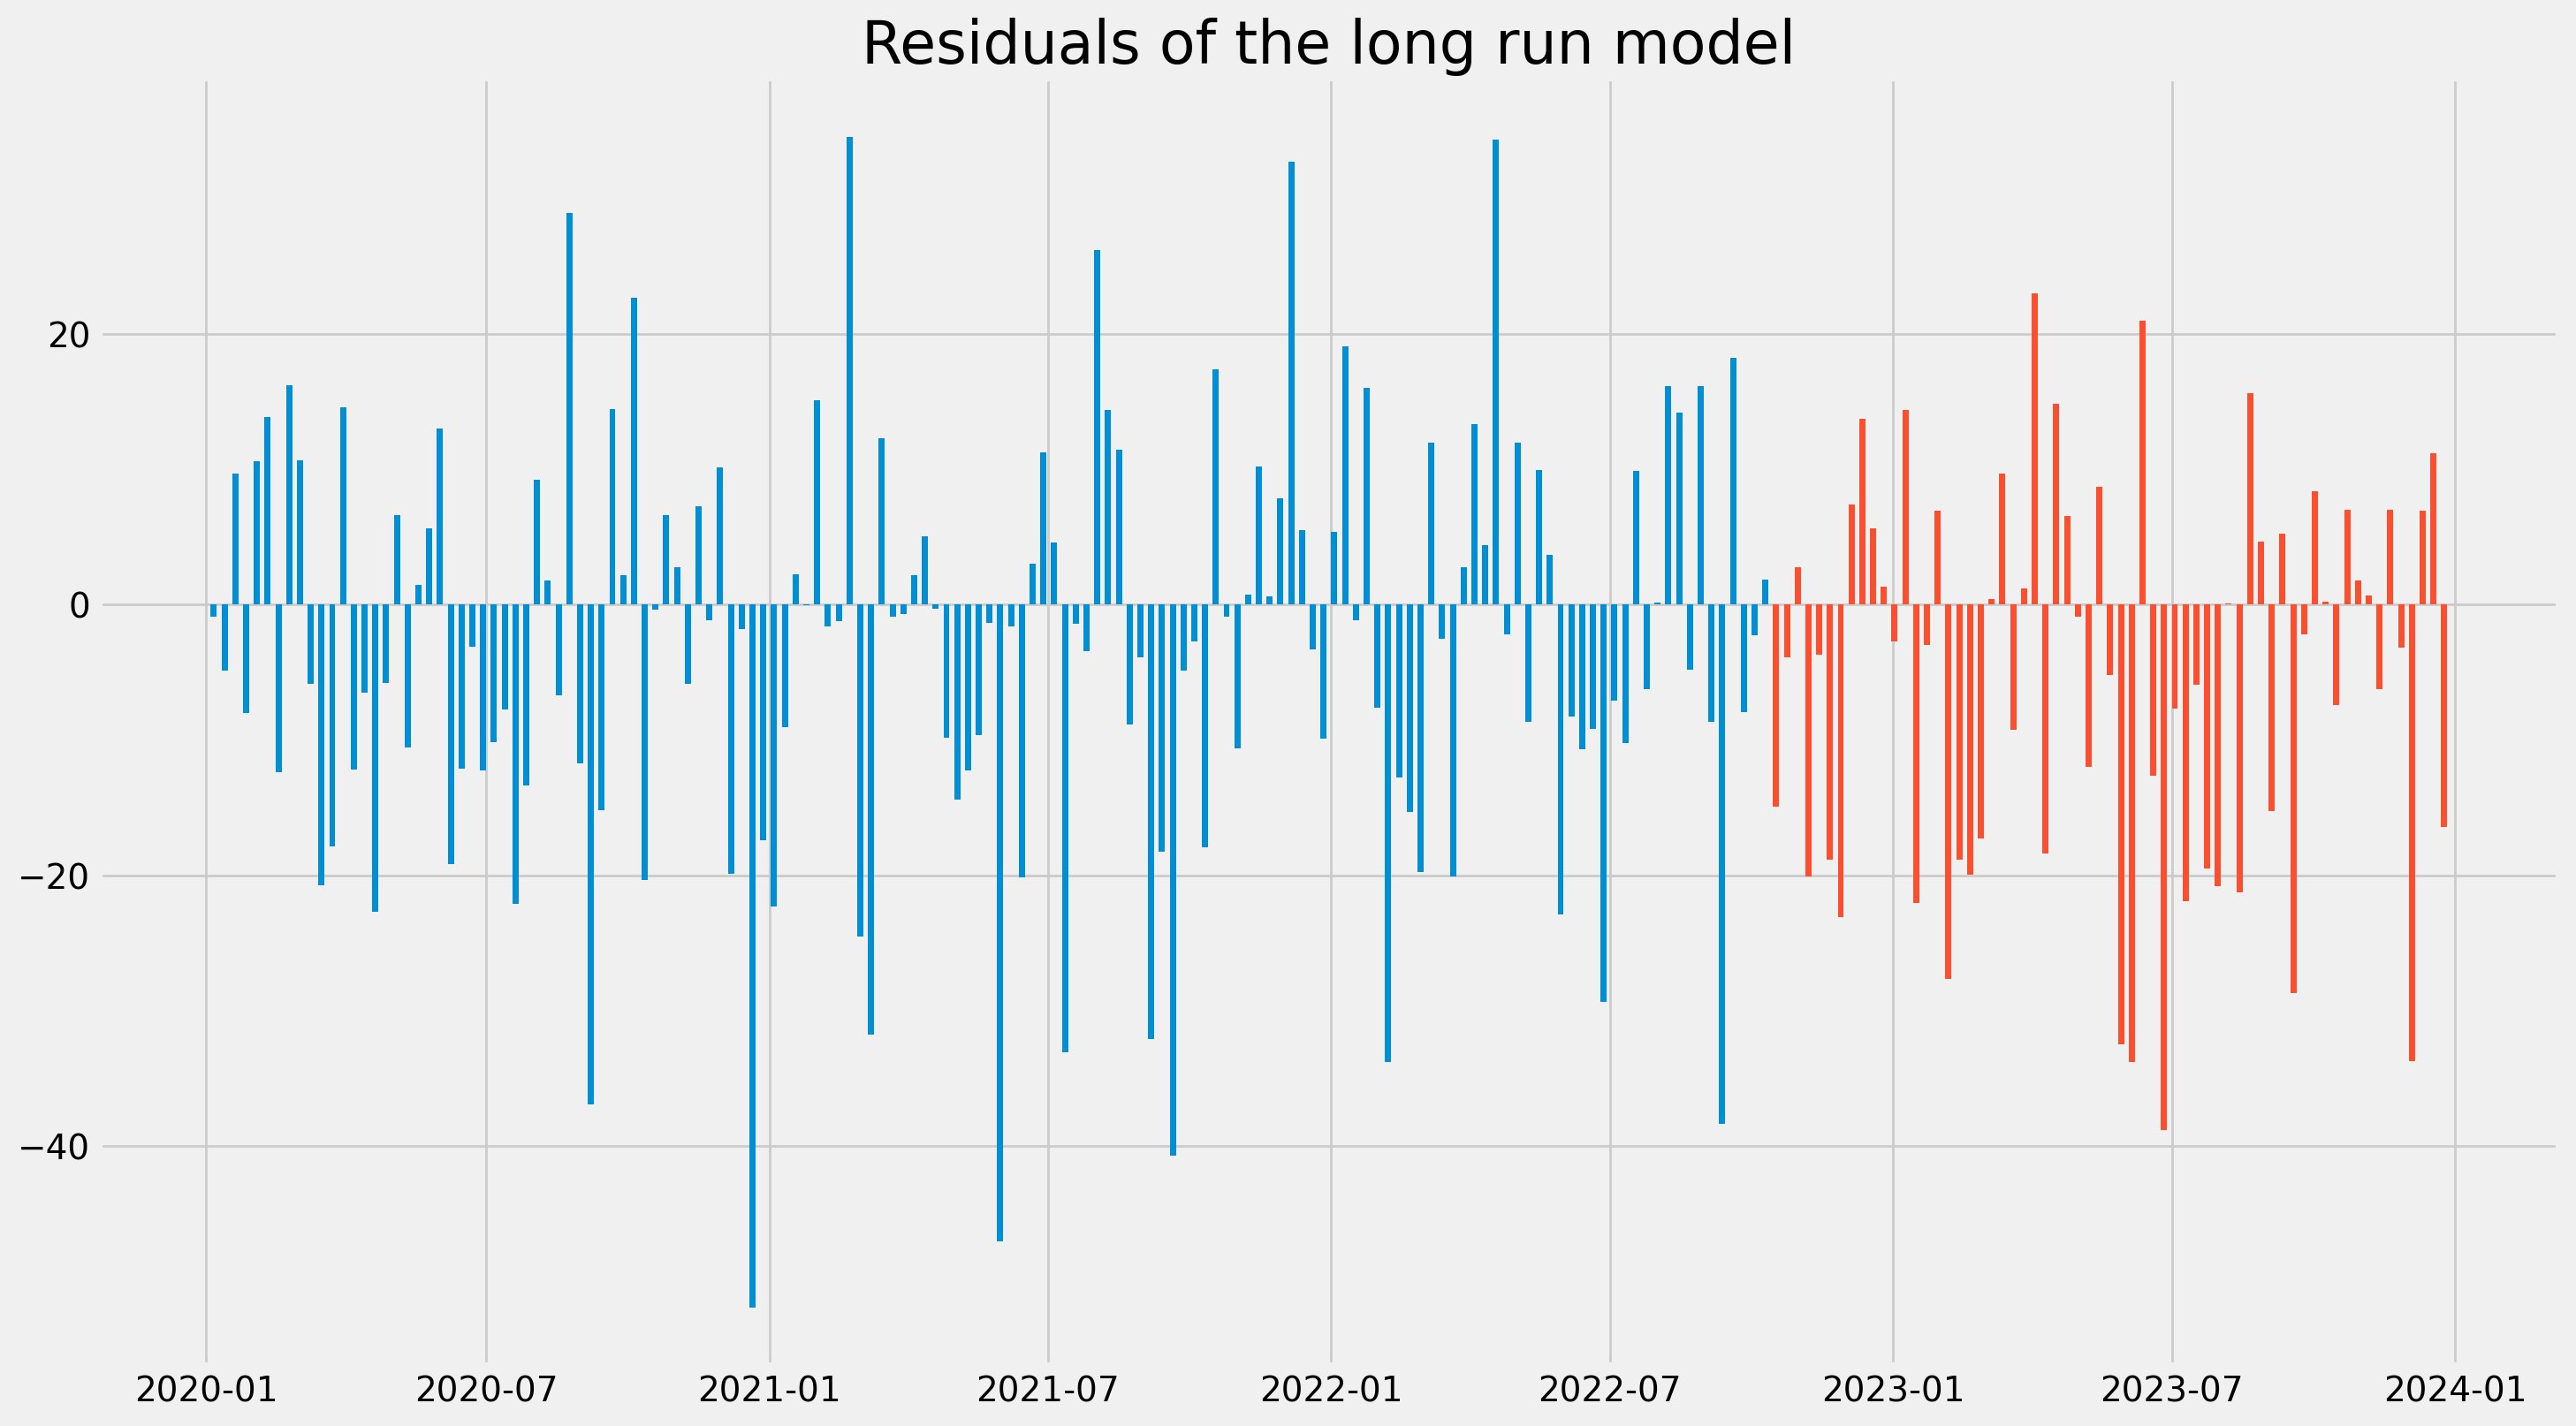

In [242]:
residuals_s = data['y_total'] - spurious_model_prediction['mean']
residuals = data['y_total'] - 2*((data['x_causal']))-50*hill(data['media'], 75, 1.4)
plt.bar(data.index[:split_index], residuals_s[:split_index], 4, label='Residuals')
plt.bar(data.index[split_index:], residuals_s[split_index:], 4, label='OOS residuals')
plt.title('Residuals of the spurious model', fontdict={'fontsize': 24})
plt.show()
plt.title('Residuals of the long run model', fontdict={'fontsize': 24})
plt.bar(data.index[:split_index], residuals[:split_index], 4, label='Residuals')
plt.bar(data.index[split_index:], residuals[split_index:], 4, label='OOS residuals')
plt.show()

In [243]:
pretty_adf(data['y_total']);

ADF Statistic: -2.712
p-value: 0.231
Fail to reject the null hypothesis, the data is non-stationary


In [244]:
pretty_kpss(data['y_total'], regression='c');

KPSS Statistic: 1.692
p-value: 0.010
Reject the null hypothesis, the data is non-stationary


/home/mattr/Scratch/non-stationary-data/utils/stats.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  crit, p, *_ = tsa.kpss(data, regression=regression)


In [245]:
crt, p = pretty_adf(data['x_causal'],regression='c')

ADF Statistic: -0.591
p-value: 0.873
Fail to reject the null hypothesis, the data is non-stationary


In [246]:
crt, p = pretty_kpss(data['x_causal'], regression='c');

KPSS Statistic: 1.693
p-value: 0.010
Reject the null hypothesis, the data is non-stationary


/home/mattr/Scratch/non-stationary-data/utils/stats.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  crit, p, *_ = tsa.kpss(data, regression=regression)


In [247]:
pretty_coint(data['y'], data['x_causal']);

Critical value: -5.786, p-value: 0.000
Reject the null hypothesis, the data is cointegrated


In [248]:
vecm_model = tsa.VECM(train[['y_total', 'x_causal', 'media_hill']], k_ar_diff=0, deterministic='c', freq='W-MON').fit()
vecm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
              Loading coefficients (alpha) for equation y_total               
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ec1            0.0765      0.011      7.088      0.000       0.055       0.098
              Loading coefficients (alpha) for equation x_causal              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ec1           -0.0026      0.002     -1.317      0.188      -0.006       0.001
             Loading coefficients (alpha) for equation media_hill             
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ec1            0.0018      0.000     13.905      0.000       0.002       0.002
          Cointegration relations for loading-coefficients-column 1           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
beta.1         1.0000          0          0      0.000       1.000       1.000
beta.2        -0.5635      0.168     -3.353      0.001      -0.893      -0.234
beta.3      -691.1937     45.499    -15.191      0.000    -780.370    -602.018
==============================================================================
"""

In [249]:
vecm_model.test_granger_causality('y_total', 'x_causal').summary()

<class 'statsmodels.iolib.table.SimpleTable'>

In [250]:
vecm_model.test_inst_causality('x_causal').summary()

<class 'statsmodels.iolib.table.SimpleTable'>

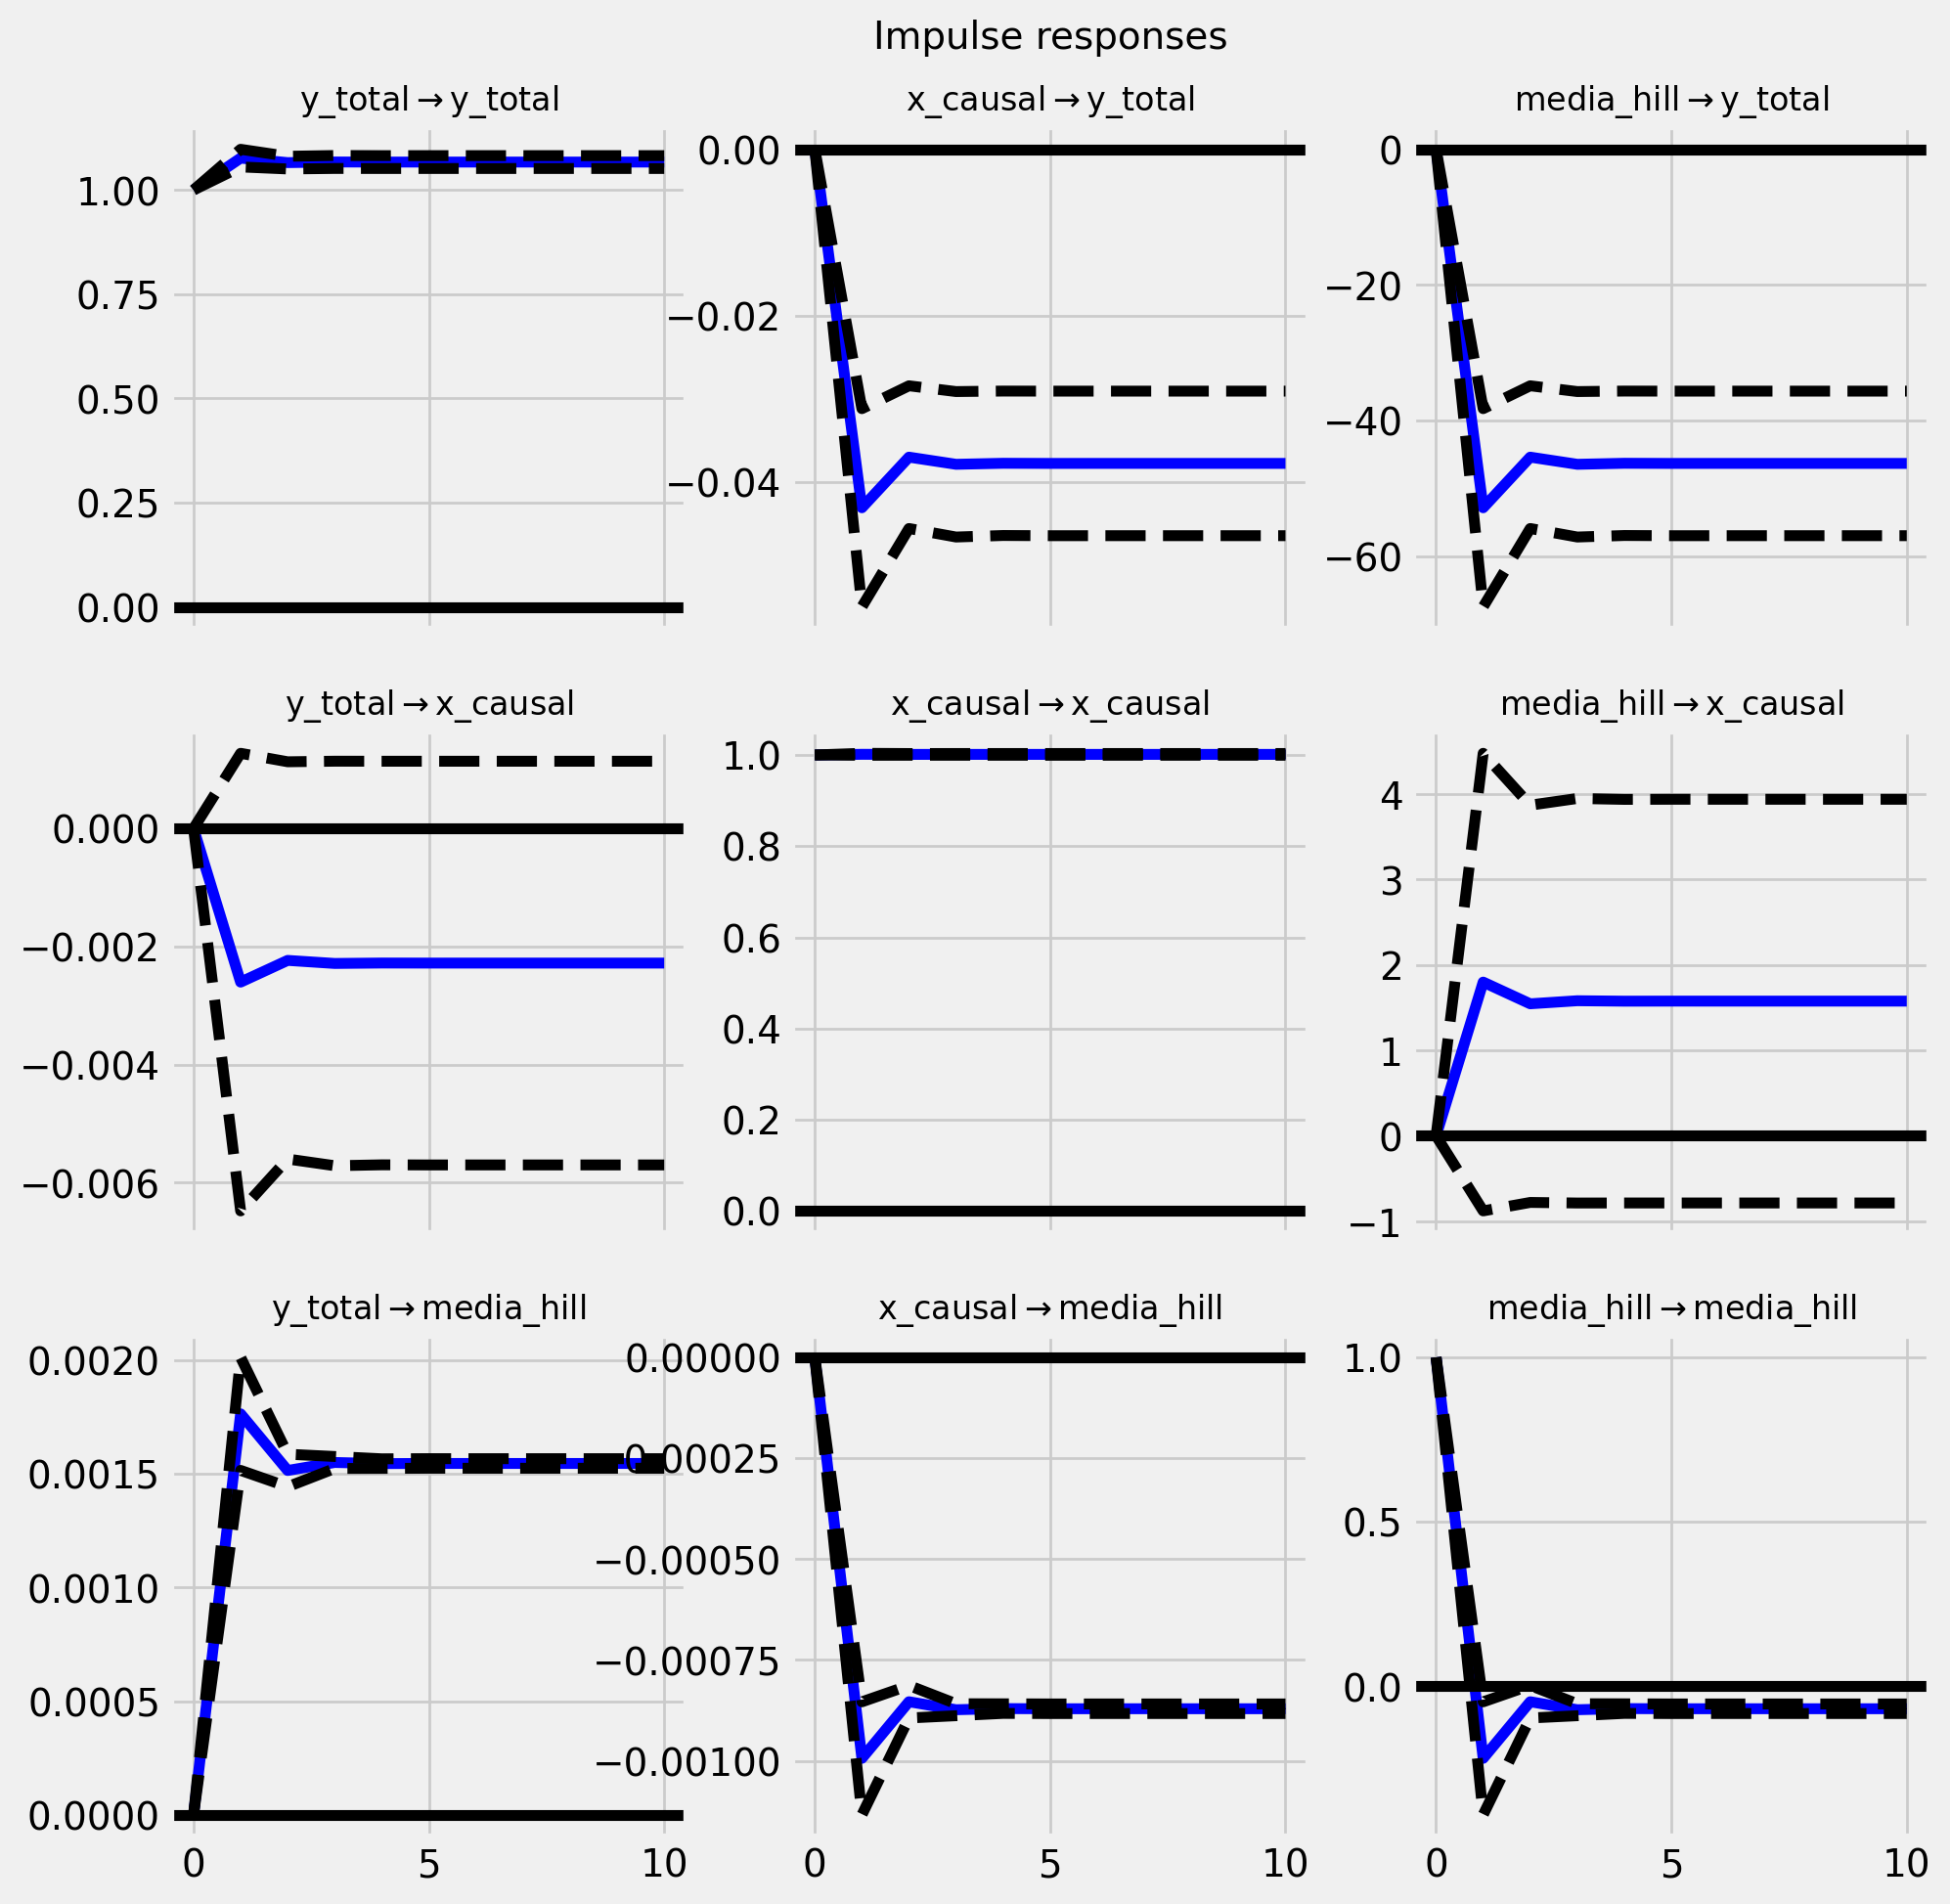

In [251]:
vecm_model.irf(10).plot();

<BarContainer object of 144 artists>

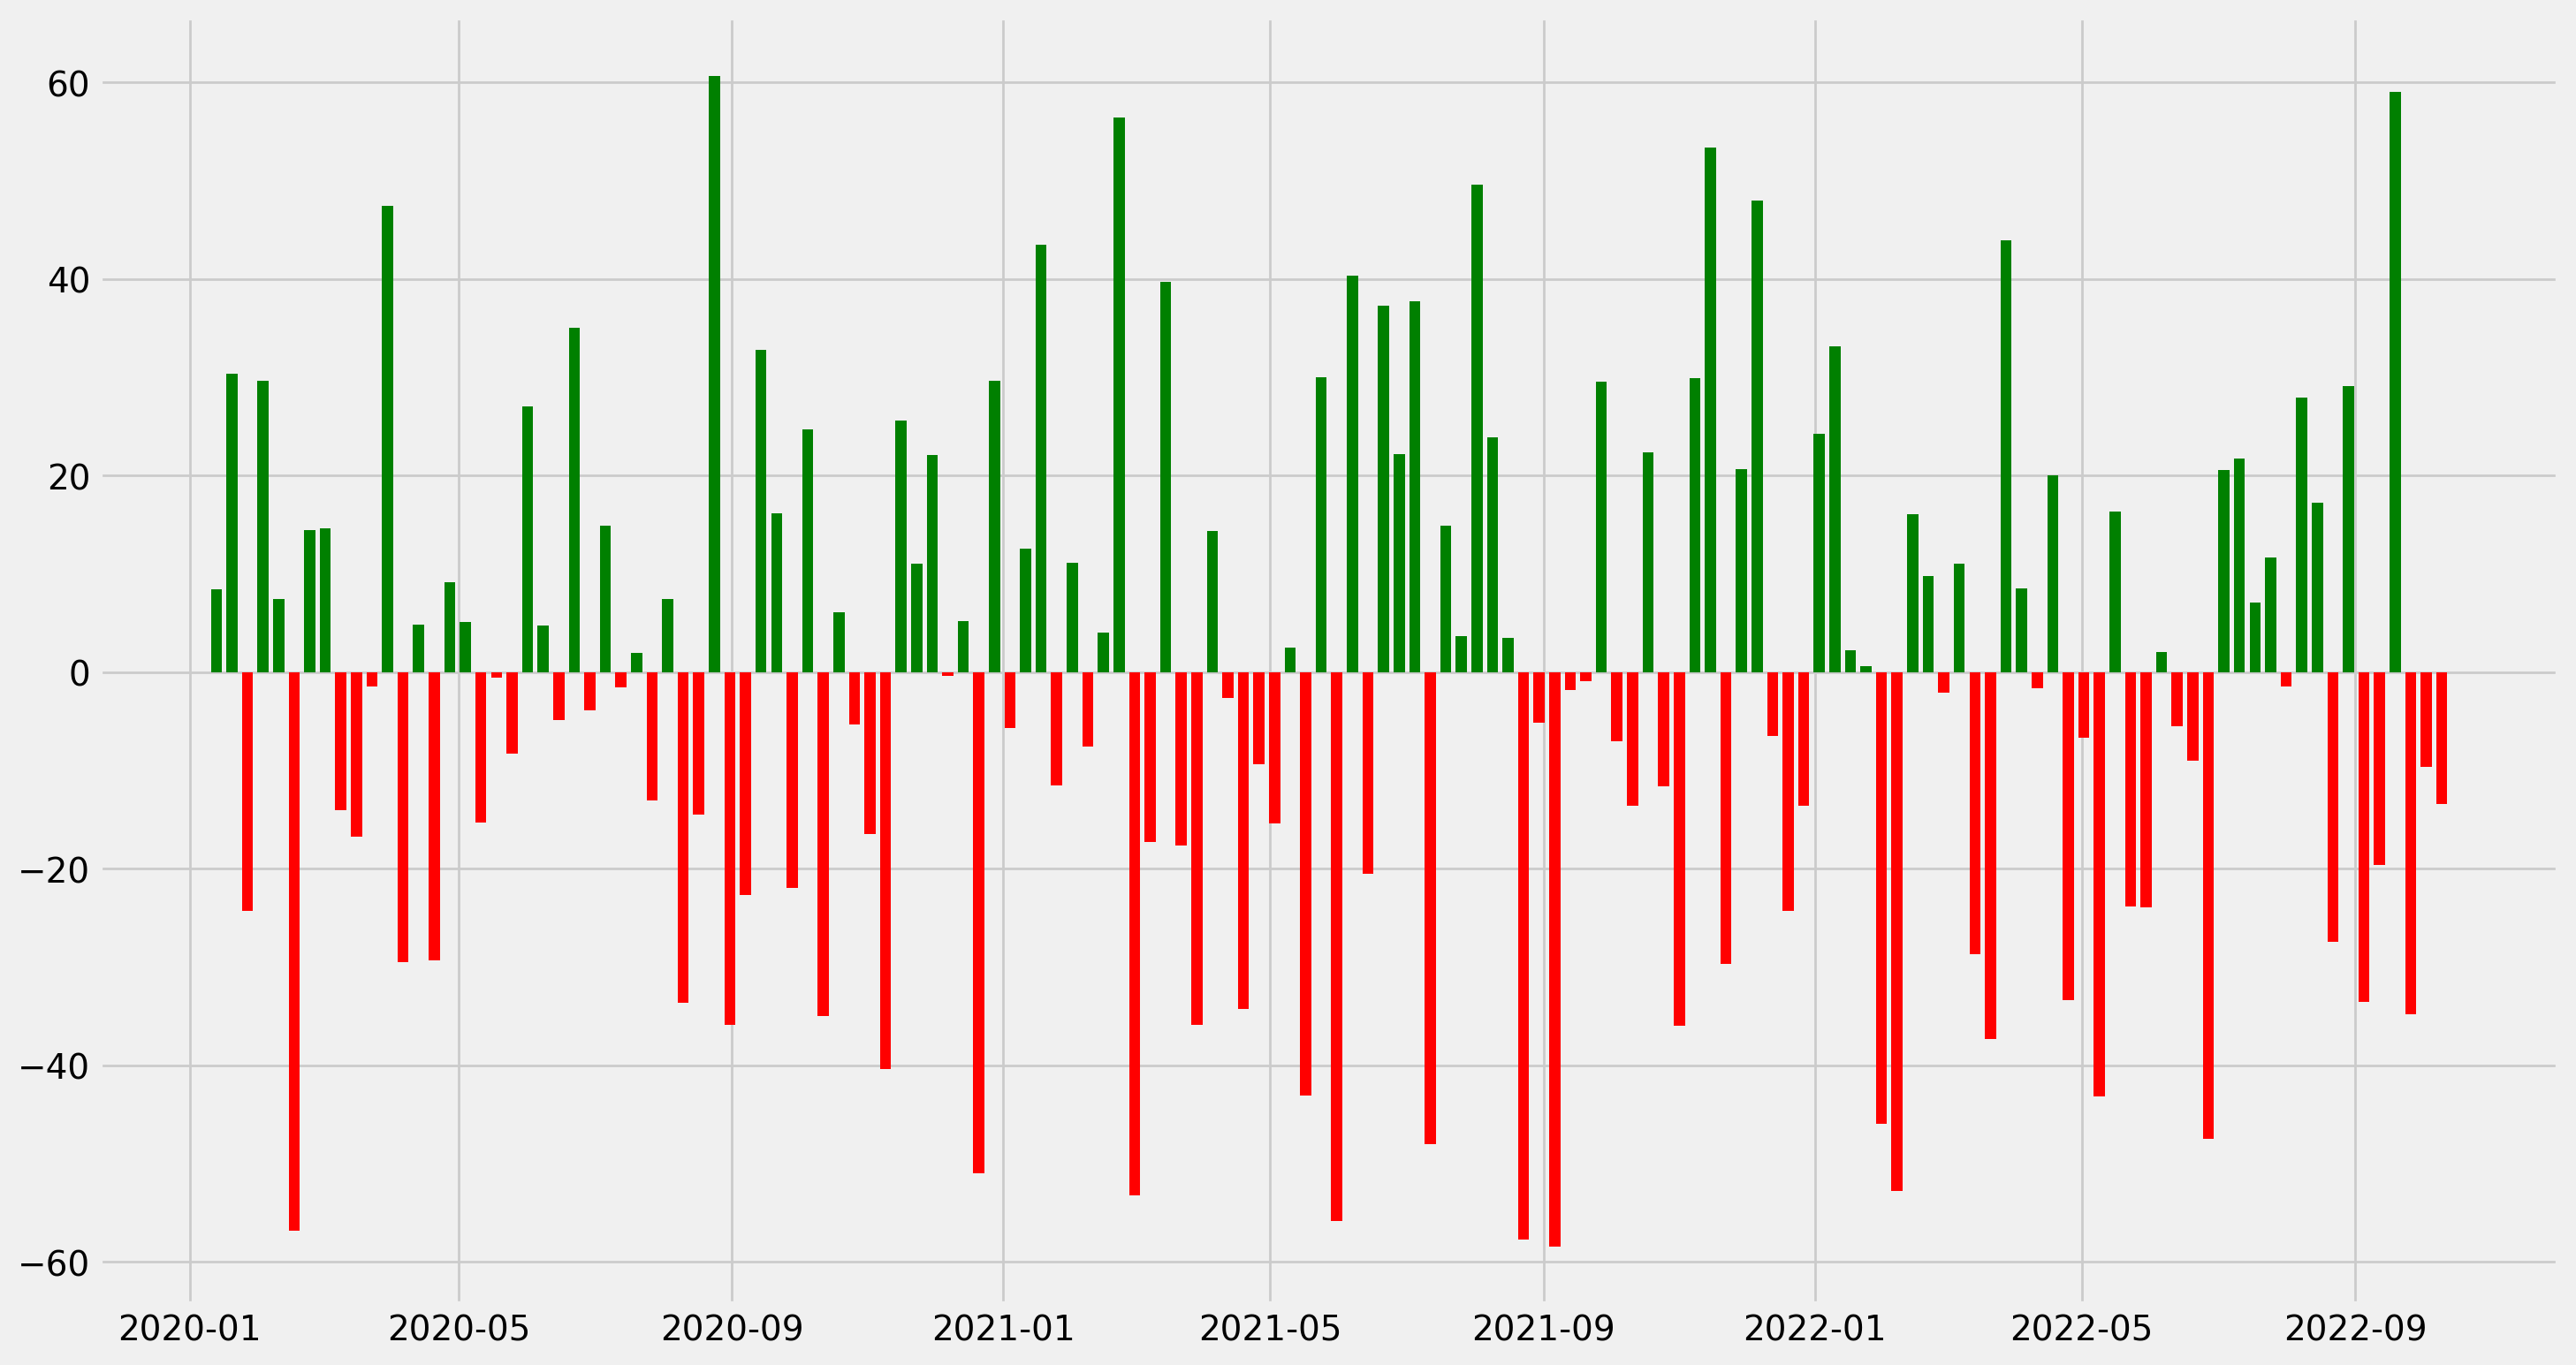

In [252]:
plt.bar(train.index[1:], vecm_model.resid[:, 0], 5, color=['g' if i > 0 else 'r' for i in vecm_model.resid[:, 0]], label='Residuals')

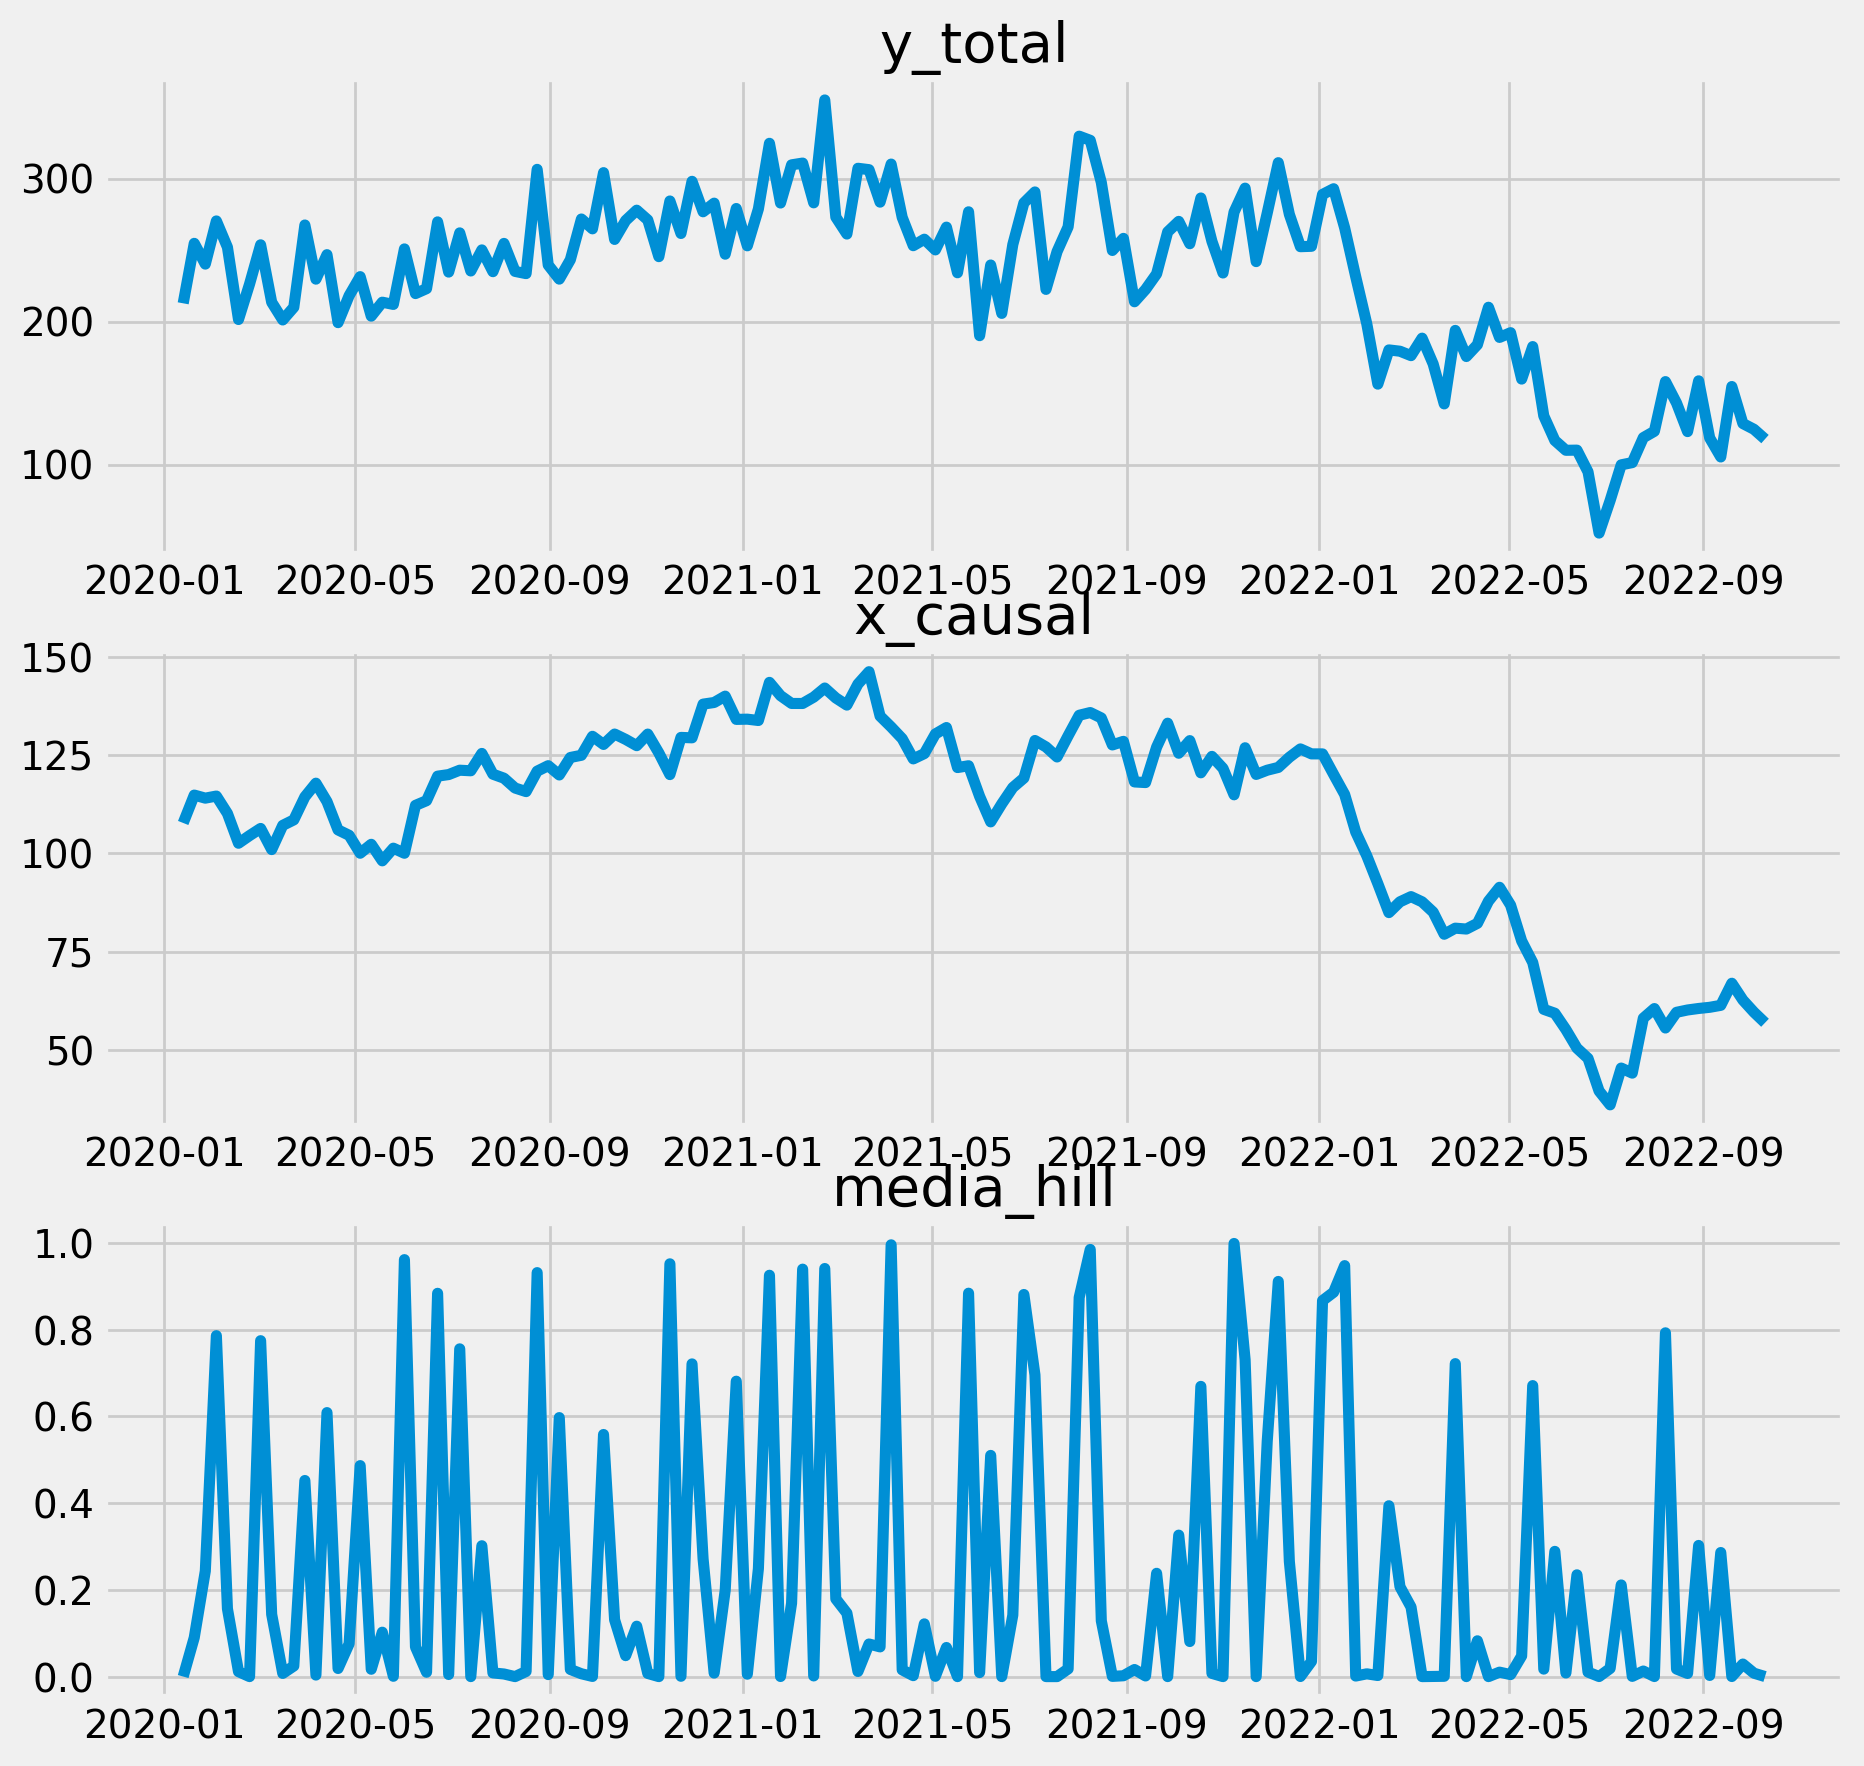

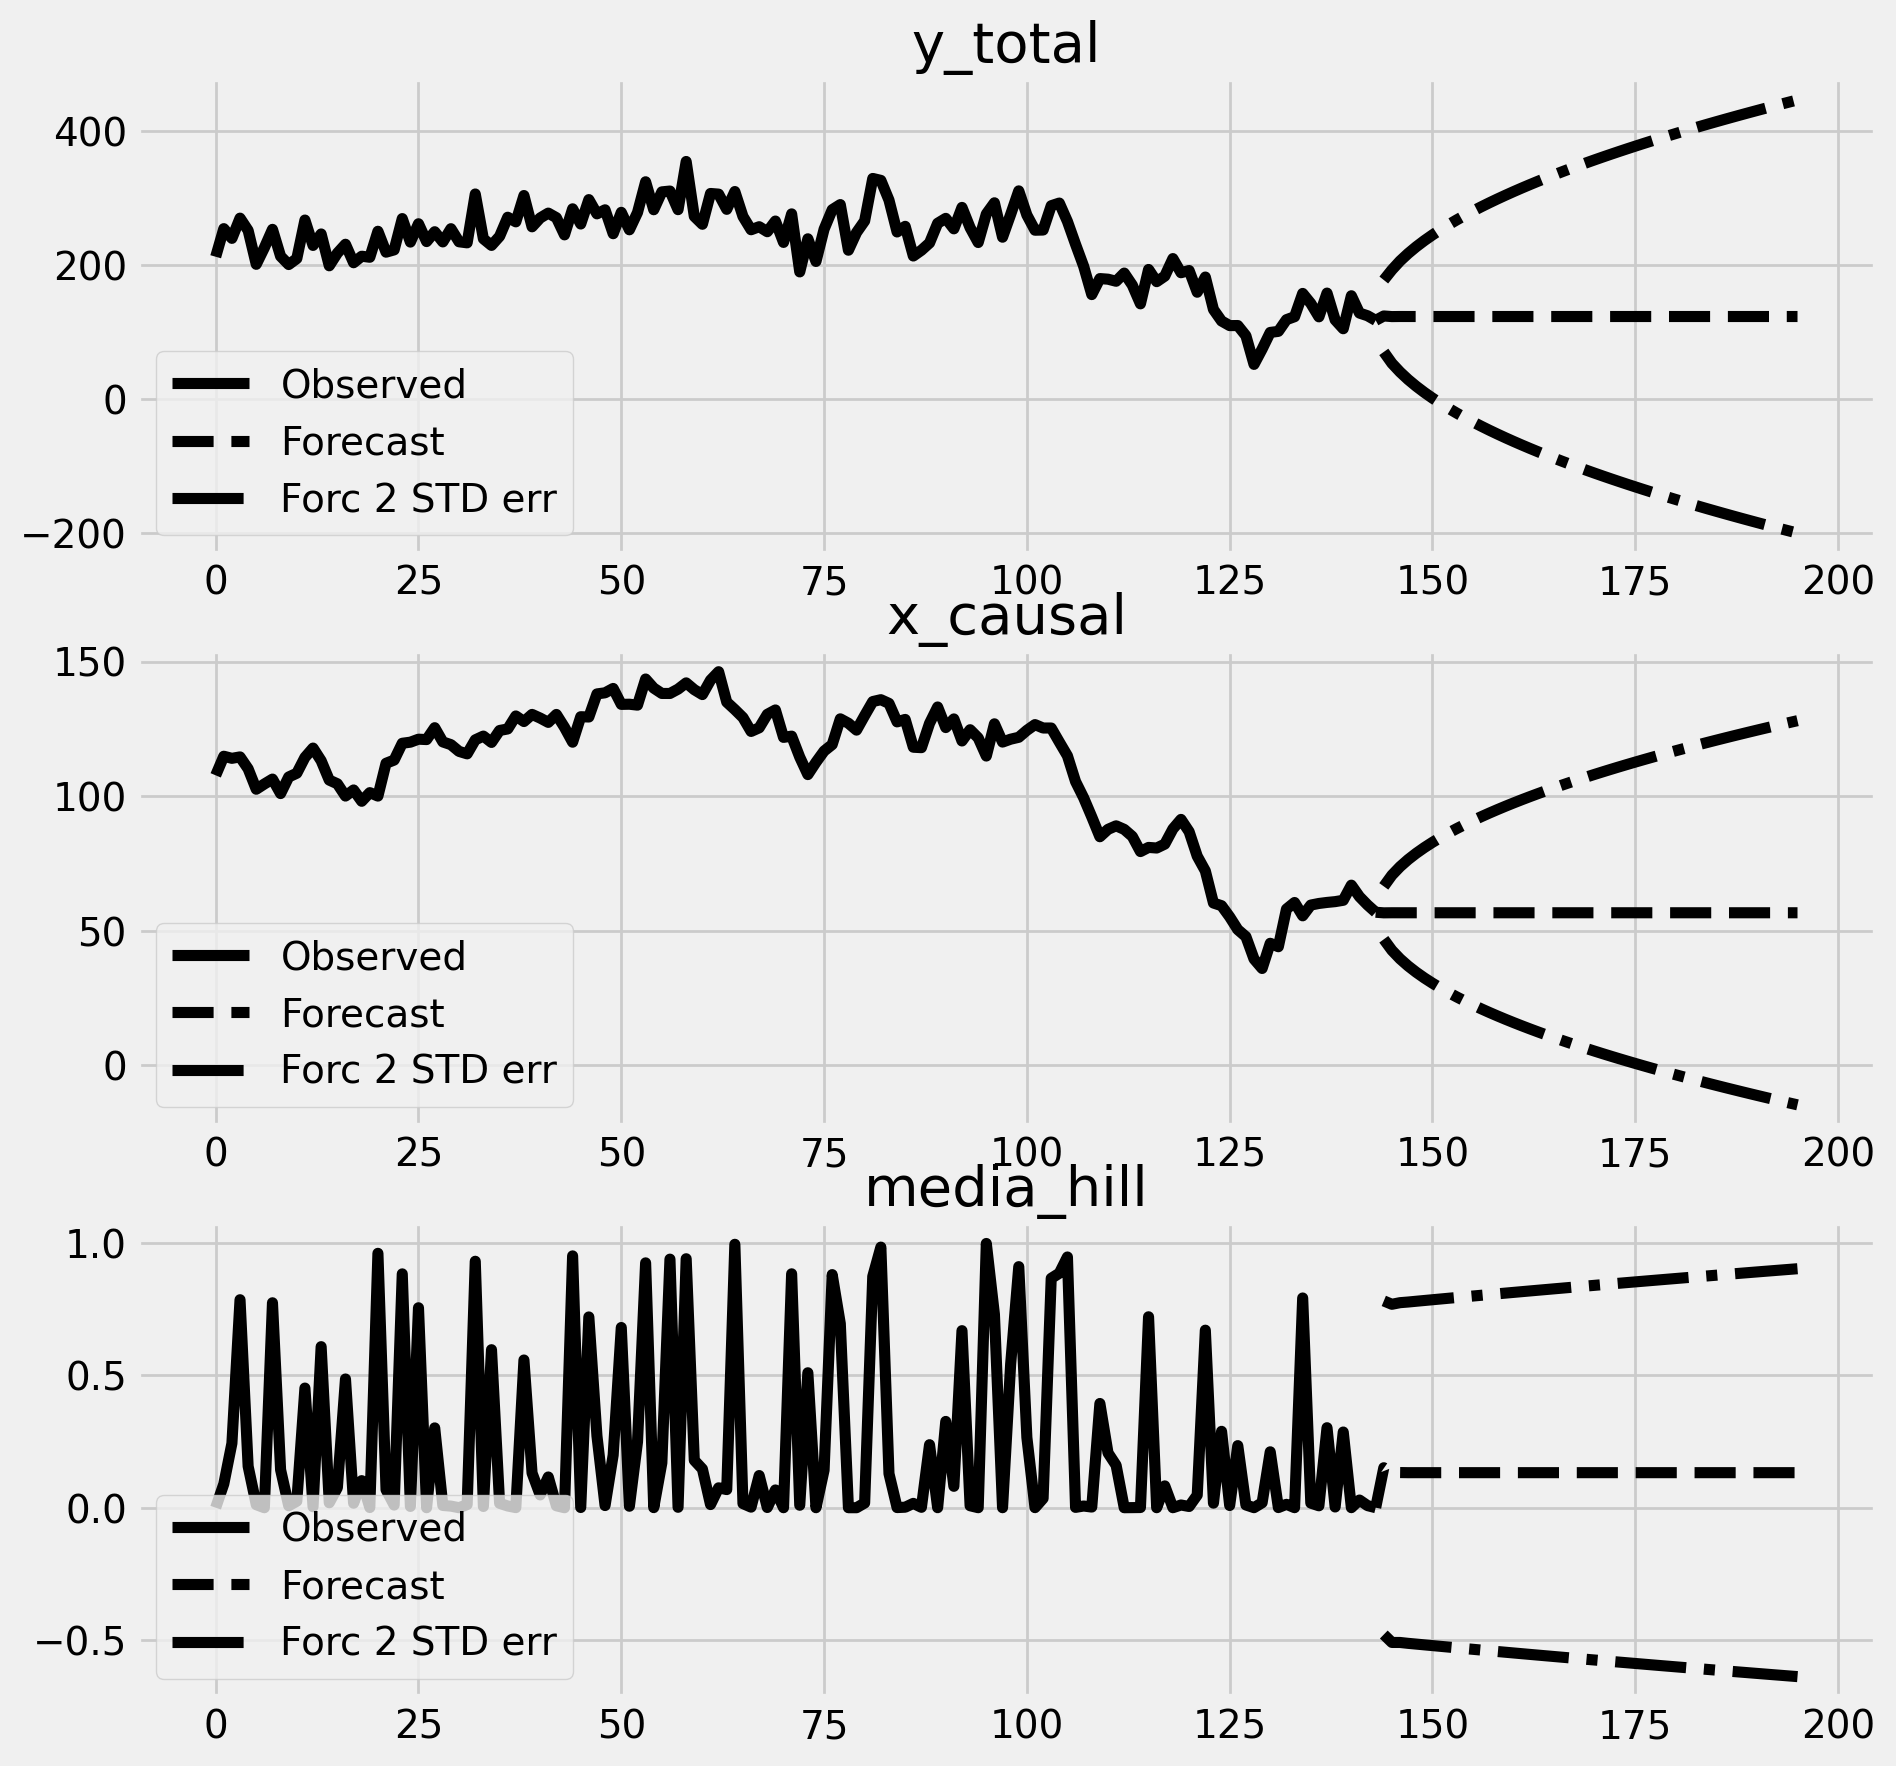

In [253]:
vecm_model.plot_data()
ax = vecm_model.plot_forecast(52)

In [254]:
econ_indicators = ["GDP", "Inflation Rate", "Unemployment Rate", "S&P", 
                   "Population", "Exports", "Intrest Rate", "Consumer Confidence", 
                   "Consumer Spending", "Industrial Production", "Retail Sales", "Median House Price",
                    "Consumer Price Index", "Producer Price Index", "Median Income", "Consumer Credit",
                   ]

10

In [261]:
def save_data(data, created, splines, name):
  spurious_cols = [col for col in train.columns if 'spurious' in col and not col.split('_')[-1] in ['0']]
  np.random.shuffle(econ_indicators)
  rename_spurious = {col: econ_indicators[i] for i, col in enumerate(spurious_cols)}
  (data
   .reset_index()
   .rename(columns={'index': 'Period', 'y_total': 'Sales', 'x_causal': 'CPI', 'media_hill': 'Media Transformed', 'x_spurious_0': 'Competitor Factor'}|rename_spurious)
   .drop(columns=['y', 'media']+[col for col in train.columns if (('spline' in col) and not col in splines)])
   .to_csv(f'{name}_data_{created}.csv', index=False)
   )
  

In [262]:
save_data(train, created, splines, 'train')
save_data(test, created, splines, 'test')

<Axes: xlabel='x_causal', ylabel='y_total'>

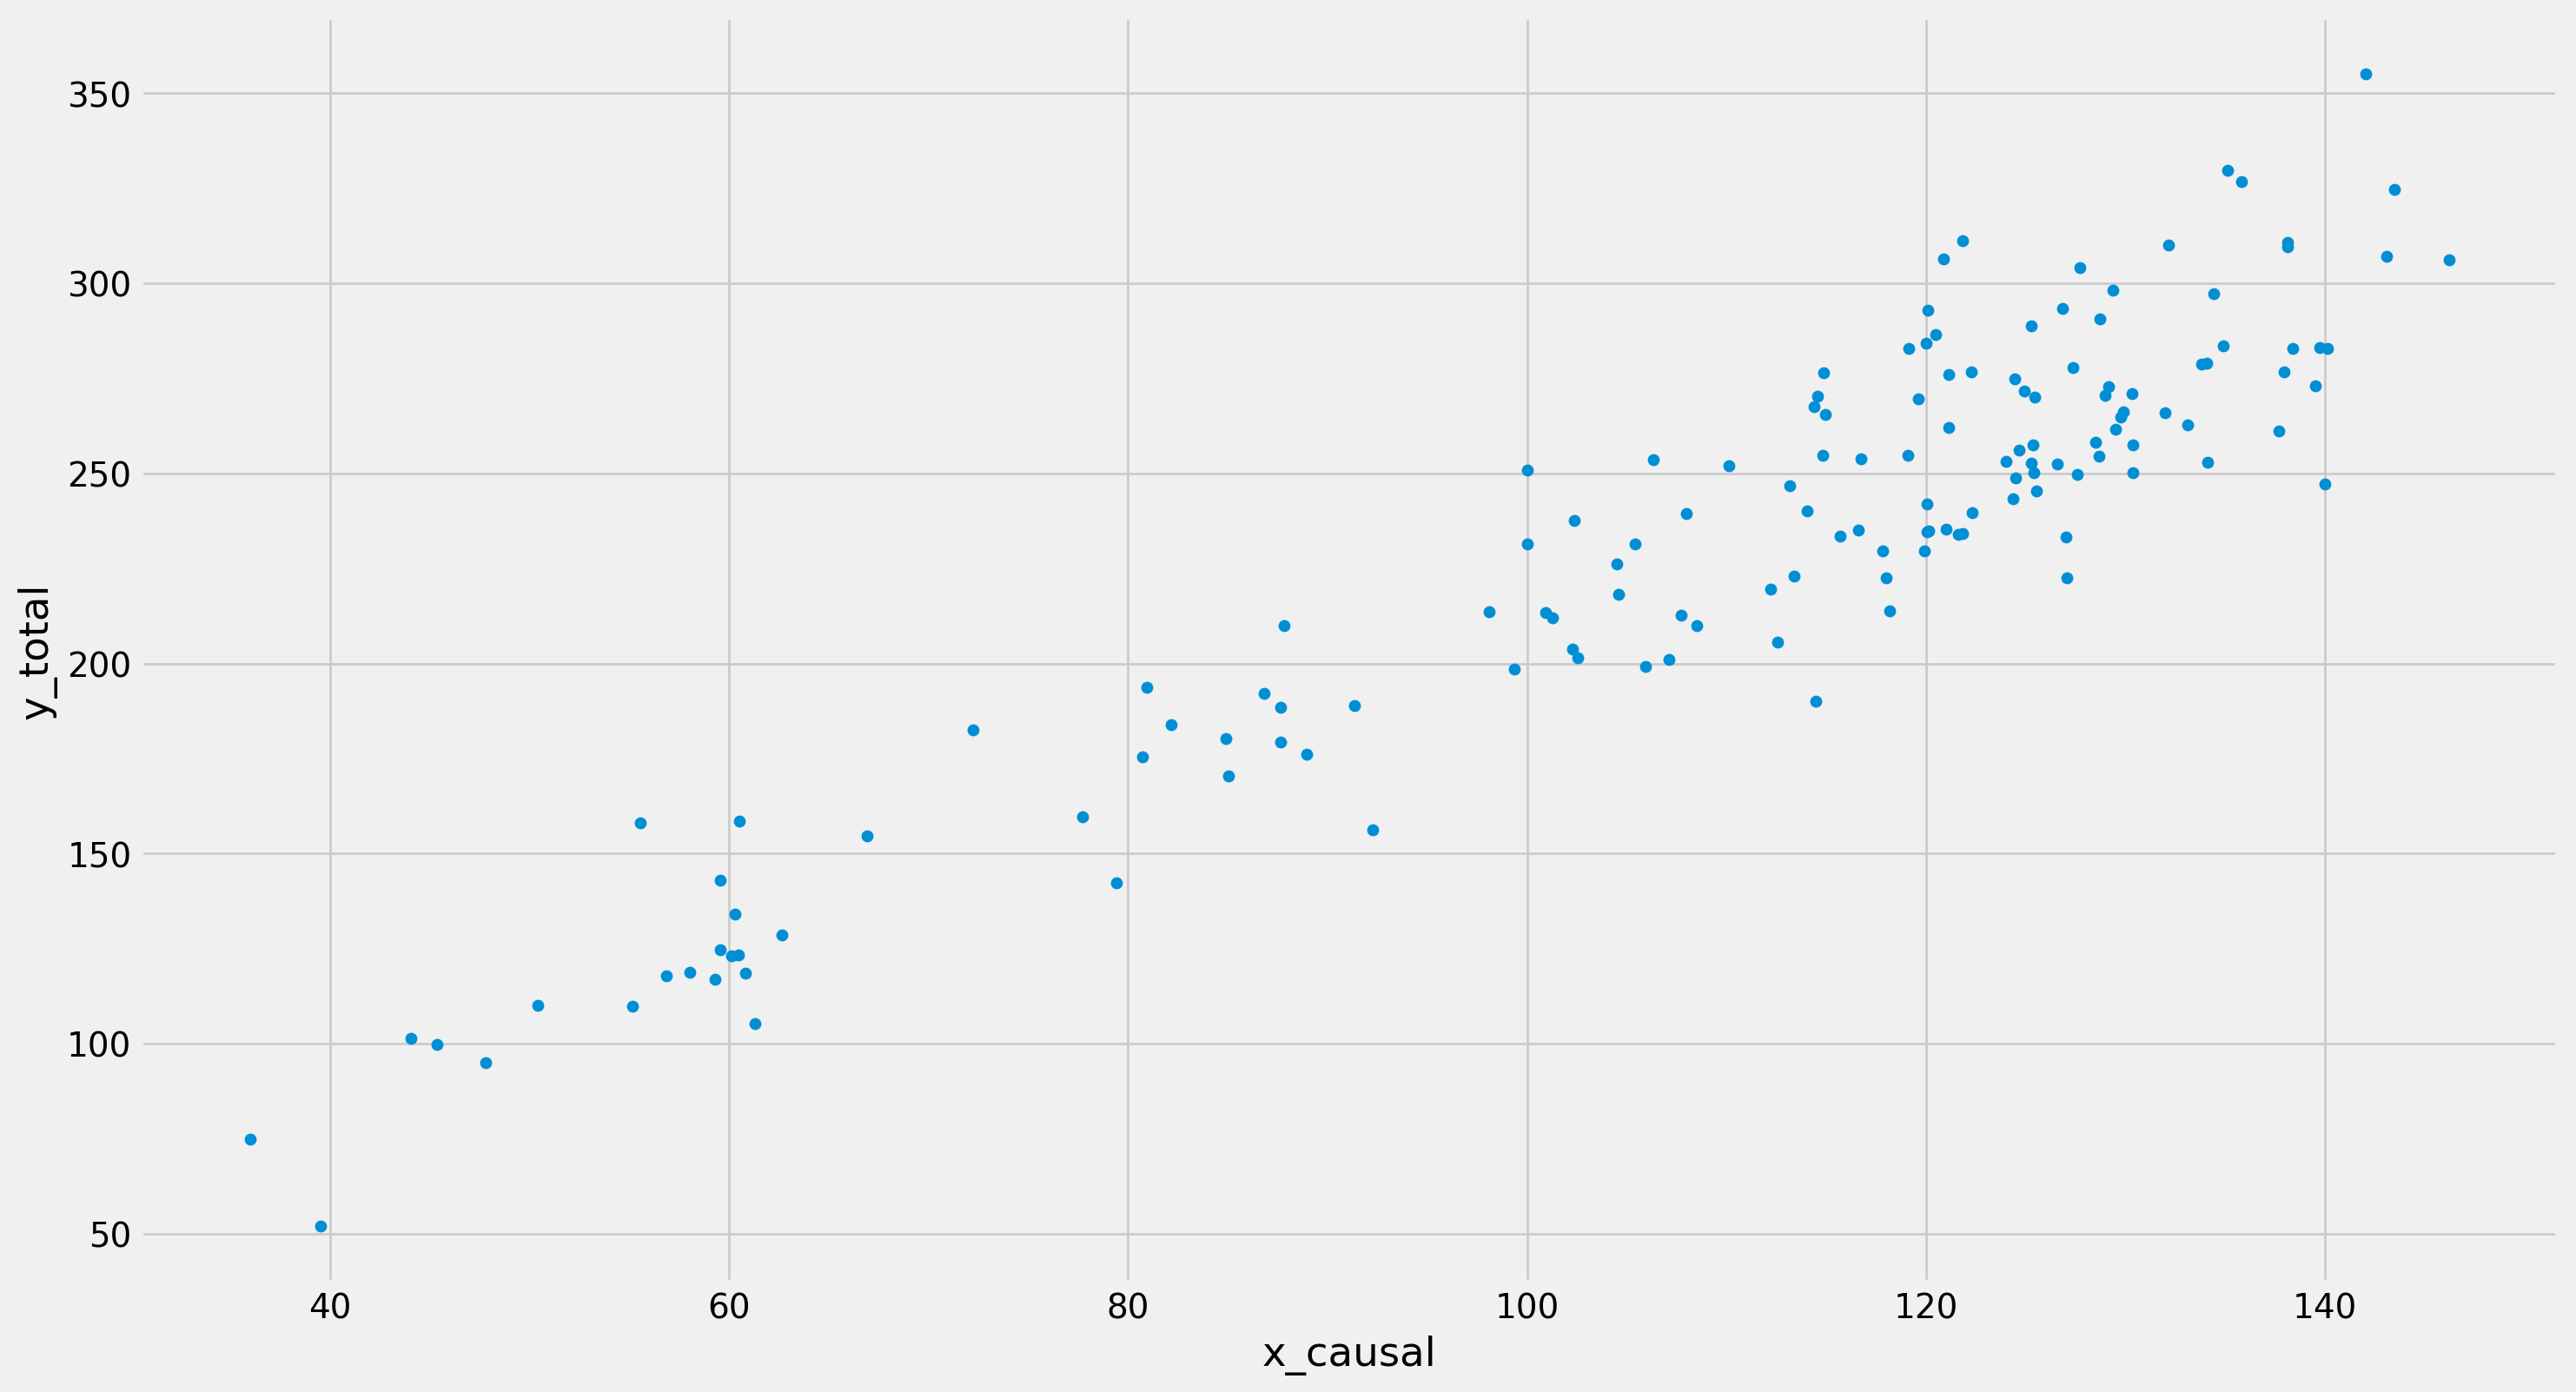

In [260]:
train.plot.scatter(x='x_causal', y='y_total')